# Dynamic Community Discovery

In [2]:
import os
import json
import numpy as np
import random

import dynetx as dn
import networkx as nx
from cdlib import algorithms, evaluation, TemporalClustering

import matplotlib.pyplot as plt

from community_evolution_analysis import CommunityEvolutionAnalysis
%load_ext autoreload
%autoreload 2

Note: to be able to use all crisp methods, you need to install some additional packages:  {'bayanpy', 'graph_tool', 'infomap', 'leidenalg'}
Note: to be able to use all crisp methods, you need to install some additional packages:  {'ASLPAw'}
Note: to be able to use all crisp methods, you need to install some additional packages:  {'infomap', 'leidenalg'}


In [3]:
FONTSIZE=16
LABELSIZE=0.9*FONTSIZE
LINEWIDTH=2.0
FIGWIDTH=8
ASPECT_RATIO=4/3

plt.rcParams['axes.labelsize'] = FONTSIZE
plt.rcParams['axes.linewidth'] = LINEWIDTH
plt.rcParams['axes.titlesize'] = 1.1*FONTSIZE
plt.rcParams['figure.figsize'] = [FIGWIDTH, FIGWIDTH/ASPECT_RATIO]
plt.rcParams['figure.labelsize'] = FONTSIZE
plt.rcParams['figure.titlesize'] = 1.1*FONTSIZE
plt.rcParams['legend.fancybox'] = False
plt.rcParams['legend.framealpha'] = 1.0
plt.rcParams['legend.fontsize'] = LABELSIZE
plt.rcParams['legend.title_fontsize'] = LABELSIZE
plt.rcParams['patch.linewidth'] = LINEWIDTH
plt.rcParams['lines.linewidth'] = LINEWIDTH
plt.rcParams['xtick.labelsize'] = LABELSIZE
plt.rcParams['ytick.labelsize'] = LABELSIZE
plt.rcParams['xtick.minor.visible'] = True
plt.rcParams['ytick.minor.visible'] = True
plt.rcParams['figure.autolayout'] = True

## Instant Optimal

In [15]:
principal_component_week_graph = []
for t in range(6):
    week_graph = nx.read_gexf(os.path.join("..","data_collection","graph", f"network_week_{t+1}.gexf"))
    week_graph_undirected = week_graph.to_undirected()
    print(f"Settimana {t+1}:")
    print(f"Number of component: {nx.number_connected_components(week_graph_undirected)}")
    size_principal_component = len(list(nx.connected_components(week_graph_undirected))[0])
    print(f"Principal component: {size_principal_component/week_graph_undirected.number_of_nodes() * 100:.1f}% ({size_principal_component}/{week_graph_undirected.number_of_nodes()})\n")
    principal_component_week_graph.append(nx.subgraph(week_graph_undirected, list(nx.connected_components(week_graph_undirected))[0]))

Settimana 1:
Number of component: 165
Principal component: 92.7% (4565/4924)

Settimana 2:
Number of component: 138
Principal component: 94.4% (5082/5384)

Settimana 3:
Number of component: 137
Principal component: 94.2% (4754/5046)

Settimana 4:
Number of component: 161
Principal component: 95.2% (6968/7319)

Settimana 5:
Number of component: 180
Principal component: 95.4% (8185/8577)

Settimana 6:
Number of component: 208
Principal component: 93.1% (6231/6695)



Come si nota dai risultati sopra la componente principale è dominante. Scelgo di utilizzare solo quella per evitare un eccesso di comminity  dovute alle varie componenti frammentate.

### Non iterazioni [MODIFICARE]

In [15]:
tc = TemporalClustering()
for t in range(6):
    coms = algorithms.louvain(principal_component_week_graph[t]) 
    tc.add_clustering(coms, t)

La cella successiva calcola la similarità tra le community di due settimane consecutive.
**NF1** è la versione normalizzata dell'F1 score, valuta la capacità di un clustering di "predire" un altro clustering.
Non è possibile utilizzare l'**NMI** perché **presuppone che l'insieme di nodi sia fisso**, altrimenti il confronto tra le distribuzioni di comunità non ha senso (se il numero di nodi è diverso, le distribuzioni di probabilità cambiano e il calcolo dell'NMI non è più ben definito). 
Invece l'**NF1** funziona a livello di comunità, confrontando la sovrapposizione tra insiemi di nodi che appartengono alle stesse comunità nei due snapshot. Se un nodo esiste solo in uno snapshot, semplicemente non partecipa al confronto.

In [16]:
trend = tc.clustering_stability_trend(evaluation.nf1)
trend

[0.005149821109123433,
 0.008521739130434781,
 0.0019288497618704002,
 0.0017283950617283954,
 0.001505497685185185]

In [17]:
tc.has_explicit_match()

False

La funzione 'community_matching' non è più valida, bisogna calcolare manualmente il matching tra le community delle differenti snapshots.

In [18]:
# Definizione della metrica di similarità (Jaccard)
def jaccard_similarity(comm1, comm2):
    set1, set2 = set(comm1), set(comm2)
    return len(set1 & set2) / len(set1 | set2) if len(set1 | set2) > 0 else 0

# Creazione dei match tra cluster di snapshot consecutivi
matches = []

# Itera tra snapshot consecutivi
for t in range(5):  # Confronta t con t+1
    c_t = tc.clusterings[t]  # Comunità al tempo t
    c_t1 = tc.clusterings[t + 1]  # Comunità al tempo t+1

    best_matches = {}  # Dizionario per salvare il miglior match per ogni comunità di t

    # Itera tra tutte le coppie di comunità tra t e t+1
    for i, com1 in enumerate(c_t.communities):
        best_jaccard = 0
        best_match = None

        for j, com2 in enumerate(c_t1.communities):
            score = jaccard_similarity(com1, com2)

            if score > best_jaccard:  # Aggiorna il miglior match per questa comunità
                best_jaccard = score
                best_match = (f"{t}_{i}", f"{t+1}_{j}", score)

        if best_match:  # Aggiunge solo il miglior match trovato
            matches.append(best_match)

# Aggiunge il matching precomputato a TemporalClustering
tc.add_matching(matches)


In [19]:
# I risultati sono del tipo ('community snapshot t', 'community snapshot t+1', 'jaccard score')
matches[0]

('0_0', '1_0', 0.17440401505646172)

In [20]:
# Verifica
c1 = tc.get_clustering_at(0).named_communities[matches[0][0]]
c2 = tc.get_clustering_at(1).named_communities[matches[0][1]]
jaccard_similarity(c1, c2)

0.17440401505646172

In [ ]:
# Seleziono solo i matches con jaccard score maggiore al 75° percentile 
jaccard_scores = np.array([t[2] for t in matches])
matches_array = np.asarray(matches)
matches_array_filtered = matches_array[jaccard_scores >= threshold]

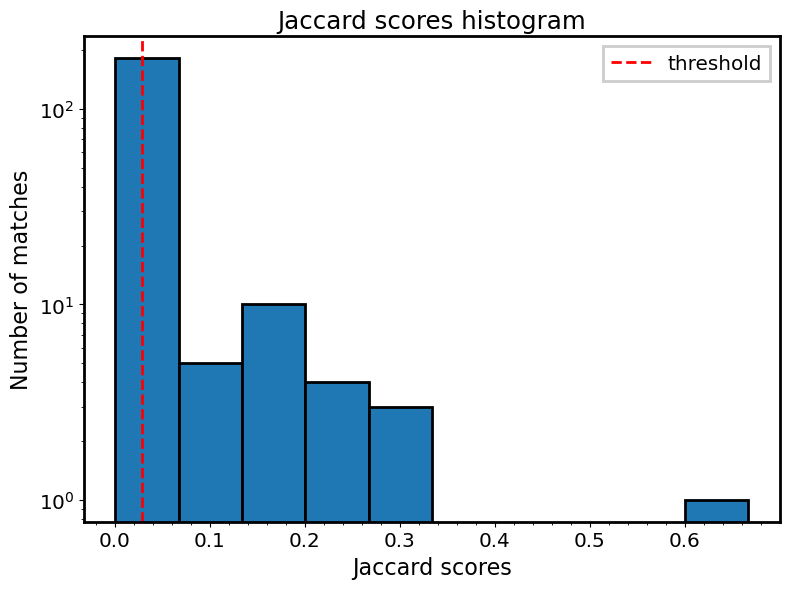

In [21]:
# Istogramma dei valori dei jaccard scores con una threshold sul 75° percentile
plt.hist(jaccard_scores, log=True, edgecolor='black')
threshold = np.percentile(jaccard_scores, 75)
plt.axvline(x=threshold, linestyle='--', color='r', label='threshold')
plt.title("Jaccard scores histogram")
plt.xlabel("Jaccard scores")
plt.ylabel("Number of matches")
plt.legend()

In [22]:
# Numero matches prima di filtrare
jaccard_scores.size

205

In [23]:
# Numero matches dopo il filtraggio
jaccard_scores[jaccard_scores >= threshold].size

52

In [25]:
def community_evolution_graph(matches_array, snapshot_list):
    # Creazione del grafo direzionale
    G = nx.DiGraph()
    # Aggiunta degli archi al grafo
    for row in matches_array:
        nodo_start, nodo_end, peso = row
        G.add_edge(nodo_start, nodo_end, weight=float(peso))
    
    for community in list(G.nodes):
        snapshot_number = int(community.split('_')[0])
        community_nodes = tc.get_clustering_at(snapshot_number).named_communities[community]
        
        # Estrazione e calcolo della media
        opinions = [snapshot_list[snapshot_number].nodes[n]["opinion"] for n in community_nodes]
        mean_opinion = sum(opinions) / len(opinions) if opinions else 0
    
        # Aggiunge l'attributo mean_opinion ai nodi del grafico
        G.nodes[community]["mean_opinion"] = mean_opinion
        
    return G

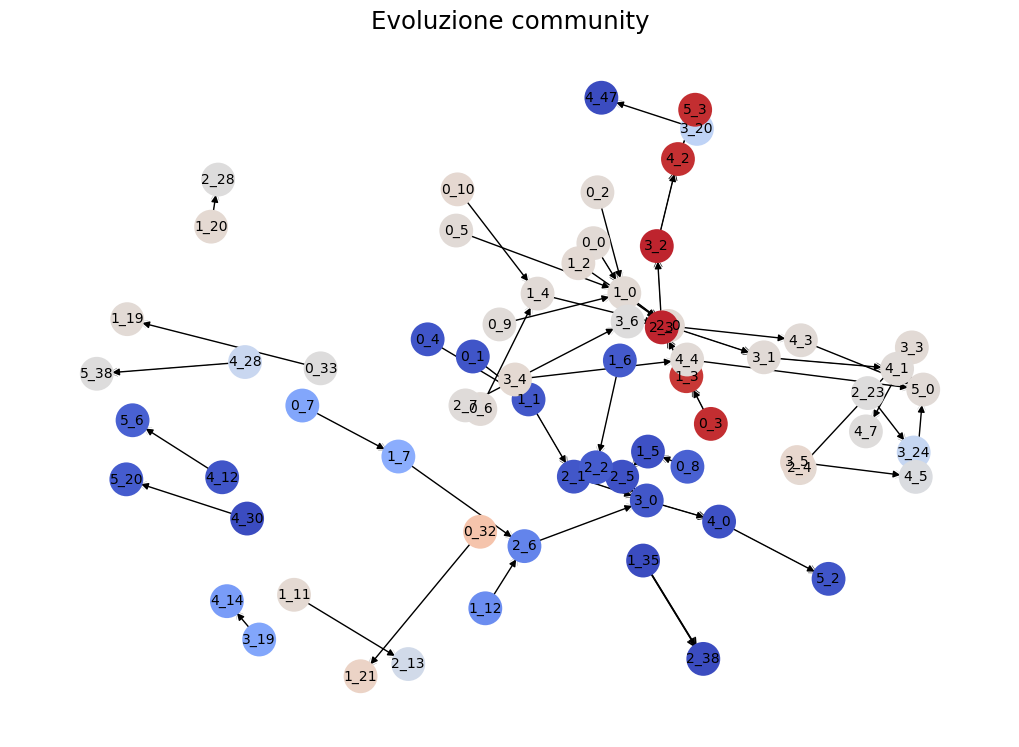

In [26]:
# Per visibilità crea il plot solo nel caso di community filtrate
G = community_evolution_graph(matches_array_filtered, principal_component_week_graph)

# Posizioni dei nodi
pos = nx.spring_layout(G, seed=42)  # Layout per disposizione dei nodi

# Estrai i valori di mean_opinion per colorare i nodi
mean_opinions = np.array([G.nodes[n]["mean_opinion"] for n in G.nodes()])

# Mappa di colori (da blu [0] a rosso [1])
node_colors = plt.cm.coolwarm(mean_opinions)

# Disegna il grafo con colori basati su mean_opinion
plt.figure(figsize=(10, 7))
nx.draw(G, pos, with_labels=True, node_size=500, node_color=node_colors, cmap=plt.cm.coolwarm, 
        font_size=10, edge_color="black")

# Estrai i pesi degli archi
weights = [G[u][v]["weight"] for u, v in G.edges()]

# Disegna gli archi con spessore basato sul peso
nx.draw_networkx_edges(G, pos, width=[w * 2 for w in weights], arrowstyle='->', arrowsize=15)

# Mostra il grafico
plt.title("Evoluzione community")
plt.savefig(os.path.join('plots', 'Evoluzione community'))
plt.show()

Nel grafico superiore non è possibile vedere dei cambi di categoria perché sono stati presi solo i collegamenti con maggior jaccard scores. Le transizioni rappresentano community simili tra loro, quindi con una bassa probabilità di cambiare la categoria.

In [27]:
from collections import defaultdict

# Per avere i risultati completi utilizzo tutti i matches
G = community_evolution_graph(matches_array, principal_component_week_graph)

# Definizione delle categorie di opinion
def categorize_opinion(mean_opinion):
    if mean_opinion <= 0.333:
        return "pro-Biden"
    elif mean_opinion >= 0.666:
        return "pro-Trump"
    else:
        return "neutral"

# Creazione del dizionario per memorizzare le categorie per snapshot
snapshot_categories = defaultdict(dict)

# Popola il dizionario con le categorie di ogni nodo in base alla snapshot
for community in G.nodes():
    snapshot_number, community_id = map(int, community.split('_'))
    mean_opinion = G.nodes[community]["mean_opinion"]
    category = categorize_opinion(mean_opinion)
    snapshot_categories[snapshot_number][community] = category

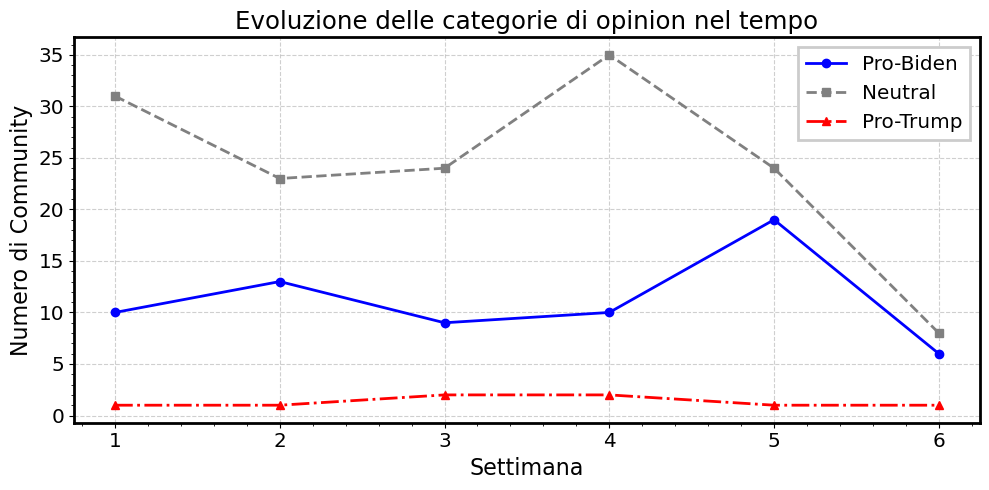

In [28]:
# Conta il numero di community in ogni categoria per ciascuna snapshot
category_counts_per_snapshot = defaultdict(lambda: {"pro-Biden": 0, "neutral": 0, "pro-Trump": 0})

for snapshot, communities in snapshot_categories.items():
    for _, category in communities.items():
        category_counts_per_snapshot[snapshot][category] += 1

# Estrai le snapshot in ordine
snapshots = sorted(category_counts_per_snapshot.keys())

# Estrarre i dati per il plot
pro_biden_counts = [category_counts_per_snapshot[s]["pro-Biden"] for s in snapshots]
neutral_counts = [category_counts_per_snapshot[s]["neutral"] for s in snapshots]
pro_trump_counts = [category_counts_per_snapshot[s]["pro-Trump"] for s in snapshots]

# Modifica i valori delle settimane per partire da 1
snapshot_labels = [s + 1 for s in snapshots]

# Creazione del plot
plt.figure(figsize=(10, 5))
plt.plot(snapshot_labels, pro_biden_counts, marker="o", linestyle="-", label="Pro-Biden", color="blue")
plt.plot(snapshot_labels, neutral_counts, marker="s", linestyle="--", label="Neutral", color="gray")
plt.plot(snapshot_labels, pro_trump_counts, marker="^", linestyle="-.", label="Pro-Trump", color="red")

# Personalizzazione del grafico
plt.xlabel("Settimana")
plt.ylabel("Numero di Community")
plt.title("Evoluzione delle categorie di opinion nel tempo")
plt.xticks(snapshot_labels)  # Ora i tick partono da 1
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)

# Mostra il grafico
plt.show()


I neutrali corrispondono principalemnte ai conservatori, quindi possiamo assumere che sono pro-Trump. Questo spiega il grosso **picco nella quarta settimana** (corrispondente all'**attentato di Trump**) sui neutrali; si noti anche un leggero picco per i pro-Trump. Altro punto interessante è il picco per i pro-Biden che si può vedere nella **quinta settimana**, che corrisponde alla **candidatura di Kamala Harris**) 

## Automatizzazione con classe e iterazioni

Il problema del calcolo precedente è che l'algoritmo louvein restituisci risultati differenti ogni volta che viene eseguito. Per tenere conto di ciò è stata creata la classe CommunityEvolutionAnalysis che automatizza i passaggi fatti prima e li itera N volte. 
Nell'iterazioni non sono comprese la threshold del jaccard score con conseguente plot dell'istogramma e del grafico delle community. E' comunque possibile eseguirli con le funzioni: **plot_jaccard_histogram** e **plot_evolution_graph**, ma rappresentano il risultato di una sola iterazione.

Nelle iterazioni **NON viene usata la threshold**

In [16]:
analysis = CommunityEvolutionAnalysis(principal_component_week_graph, threshold_percentile=75)

In [17]:
n_iter = 30

100%|███████████████████████████████████████████| 30/30 [03:37<00:00,  7.25s/it]


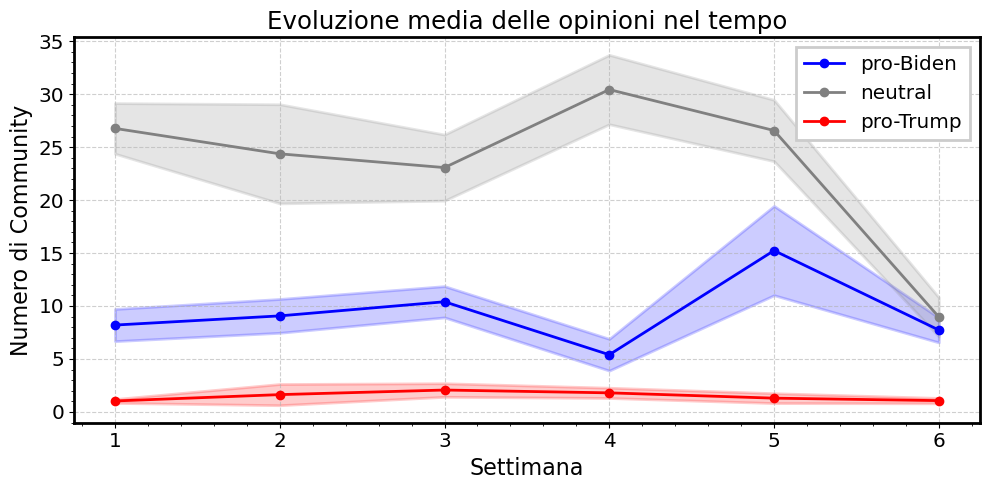

In [18]:
averages_H1, stds_H1 = analysis.analyze_community_evolution_multiple(iterations=n_iter, plot=True, save=True)

### Visualizzazioni
Le seguenti due celle servono SOLO per la visualizzazione, ogni volta che vengono eseguite i risultati sono diversi. 

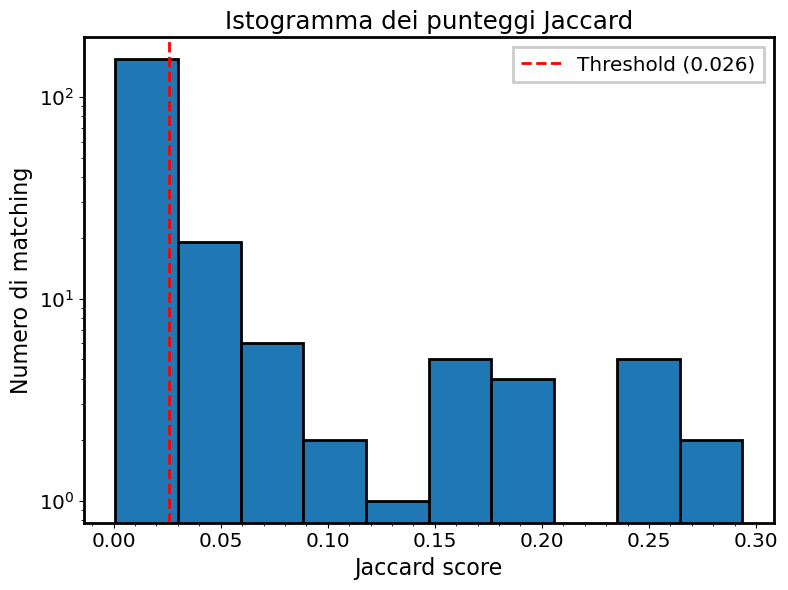

In [51]:
analysis.compute_clusterings()
analysis.compute_matches()
analysis.plot_jaccard_histogram()

Matching filtrati con soglia (percentile 75): 0.026


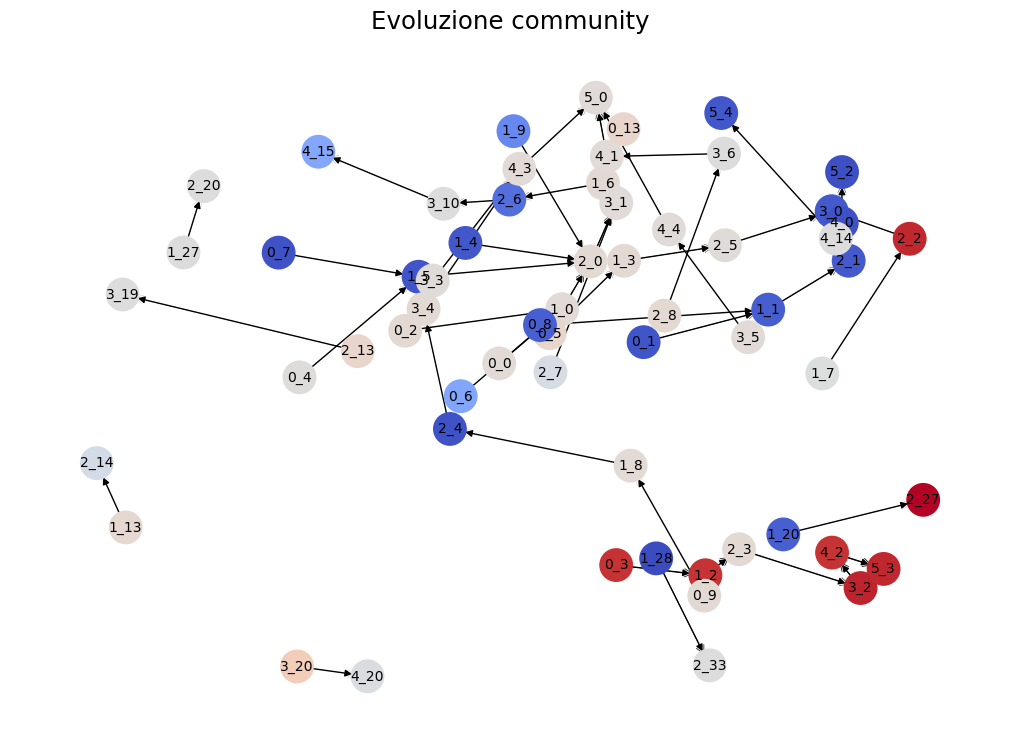

In [52]:
analysis.plot_evolution_graph(use_filtered=True, save=False)

## Validazione

### Null model: Sequence shuffling

In [4]:
LOAD = True

if LOAD:
    with open(os.path.join("shuffles","H0_sequencial_permutation.json"), "r") as json_file:
        loaded_data = json.load(json_file)
    
    # Converti le liste Python di nuovo in array numpy
    averages_H0_seq = {key: np.array(value) for key, value in loaded_data["averages_H0"].items()}
    stds_H0_seq = {key: np.array(value) for key, value in loaded_data["stds_H0"].items()}

    with open(os.path.join("shuffles","H0_sequencial_all_permutation.json"), 'r') as f:
        all_averages_H0_seq = json.load(f)

In [33]:
from itertools import permutations

# Genera tutte le permutazioni escludendo quella originale (tutti ordinamenti temporali possibili)
all_permutations = list(permutations(principal_component_week_graph))
filtered_permutations = [p for p in all_permutations if p != tuple(principal_component_week_graph)]

len(filtered_permutations)

719

In [36]:
%%time

num_shuffles = len(filtered_permutations) # 719  
num_snapshots = len(principal_component_week_graph)
all_averages_H0_seq = []
#all_stds_H0_seq = []
""" # Serve per indicare un numero preciso di shuffle (l'estrazione è fatta con ripetizioni)
for i in range(num_shuffles): 
    print(f"Shuffle {i+1}/{num_shuffles}")
    # Crea una copia della lista originale e la mescola
    shuffled_graphs = principal_component_week_graph.copy()
    random.shuffle(shuffled_graphs)
"""
for i, shuffled_graphs in enumerate(filtered_permutations):
    print(f"Shuffle {i+1}/{num_shuffles}")
    
    # Crea una nuova istanza della classe con la lista mescolata
    analysis = CommunityEvolutionAnalysis(shuffled_graphs, threshold_percentile=75)
    
    # Calcola gli stats per questa lista (con n_iter iterazioni interne)
    averages, stds = analysis.analyze_community_evolution_multiple(iterations=1,
                                                                   plot=False,
                                                                   save=False
                                                                  )
    # Salva i risultati
    all_averages_H0_seq.append(averages)
    #all_stds_H0_seq.append(stds)

# Calcola la media delle medie e la media delle stds
averages_H0_seq = {"pro-Biden": [], "neutral": [], "pro-Trump": []}
stds_H0_seq = {"pro-Biden": [], "neutral": [], "pro-Trump": []}

snapshots = np.array([s + 1 for s in range(num_snapshots)])  # Le settimane partono da 1
for category in averages_H0_seq.keys():
    for s in range(num_snapshots):
        # Raccogli tutti i valori per la snapshot s di questa categoria, provenienti dai vari shuffle
        values = [all_averages_H0_seq[i][category][s] for i in range(num_shuffles)]
        #std_values = [all_stds_H0_seq[i][category][s] for i in range(num_shuffles)]
        averages_H0_seq[category].append(np.mean(values))
        stds_H0_seq[category].append(np.std(values, ddof=1))#/np.sqrt(num_shuffles))

# Converti in array per il plotting
for category in averages_H0_seq:
    averages_H0_seq[category] = np.array(averages_H0_seq[category])
    stds_H0_seq[category] = np.array(stds_H0_seq[category])

Shuffle 1/719


100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.56s/it]


Shuffle 2/719


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.64s/it]


Shuffle 3/719


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.67s/it]


Shuffle 4/719


100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.04s/it]


Shuffle 5/719


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.27s/it]


Shuffle 6/719


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.12s/it]


Shuffle 7/719


100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.39s/it]


Shuffle 8/719


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.33s/it]


Shuffle 9/719


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.07s/it]


Shuffle 10/719


100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.57s/it]


Shuffle 11/719


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.65s/it]


Shuffle 12/719


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.61s/it]


Shuffle 13/719


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.18s/it]


Shuffle 14/719


100%|█████████████████████████████████████████████| 1/1 [00:04<00:00,  4.86s/it]


Shuffle 15/719


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.32s/it]


Shuffle 16/719


100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.62s/it]


Shuffle 17/719


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.96s/it]


Shuffle 18/719


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.50s/it]


Shuffle 19/719


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.99s/it]


Shuffle 20/719


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.74s/it]


Shuffle 21/719


100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.28s/it]


Shuffle 22/719


100%|█████████████████████████████████████████████| 1/1 [00:09<00:00,  9.27s/it]


Shuffle 23/719


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.73s/it]


Shuffle 24/719


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  8.00s/it]


Shuffle 25/719


100%|█████████████████████████████████████████████| 1/1 [00:09<00:00,  9.20s/it]


Shuffle 26/719


100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.41s/it]


Shuffle 27/719


100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.13s/it]


Shuffle 28/719


100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.46s/it]


Shuffle 29/719


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.44s/it]


Shuffle 30/719


100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.11s/it]


Shuffle 31/719


100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.43s/it]


Shuffle 32/719


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.43s/it]


Shuffle 33/719


100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.13s/it]


Shuffle 34/719


100%|█████████████████████████████████████████████| 1/1 [00:09<00:00,  9.84s/it]


Shuffle 35/719


100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.55s/it]


Shuffle 36/719


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.75s/it]


Shuffle 37/719


100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.24s/it]


Shuffle 38/719


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.68s/it]


Shuffle 39/719


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.00s/it]


Shuffle 40/719


100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.07s/it]


Shuffle 41/719


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.85s/it]


Shuffle 42/719


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.03s/it]


Shuffle 43/719


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.30s/it]


Shuffle 44/719


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.61s/it]


Shuffle 45/719


100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.79s/it]


Shuffle 46/719


100%|█████████████████████████████████████████████| 1/1 [00:09<00:00,  9.61s/it]


Shuffle 47/719


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.73s/it]


Shuffle 48/719


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.72s/it]


Shuffle 49/719


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.08s/it]


Shuffle 50/719


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.00s/it]


Shuffle 51/719


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.07s/it]


Shuffle 52/719


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.03s/it]


Shuffle 53/719


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.69s/it]


Shuffle 54/719


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.60s/it]


Shuffle 55/719


100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.71s/it]


Shuffle 56/719


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.46s/it]


Shuffle 57/719


100%|█████████████████████████████████████████████| 1/1 [00:09<00:00,  9.11s/it]


Shuffle 58/719


100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.00s/it]


Shuffle 59/719


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.47s/it]


Shuffle 60/719


100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.14s/it]


Shuffle 61/719


100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.18s/it]


Shuffle 62/719


100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.29s/it]


Shuffle 63/719


100%|█████████████████████████████████████████████| 1/1 [00:09<00:00,  9.54s/it]


Shuffle 64/719


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.84s/it]


Shuffle 65/719


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.62s/it]


Shuffle 66/719


100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.71s/it]


Shuffle 67/719


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.48s/it]


Shuffle 68/719


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.94s/it]


Shuffle 69/719


100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.32s/it]


Shuffle 70/719


100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.07s/it]


Shuffle 71/719


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.67s/it]


Shuffle 72/719


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.37s/it]


Shuffle 73/719


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.50s/it]


Shuffle 74/719


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.51s/it]


Shuffle 75/719


100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.60s/it]


Shuffle 76/719


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.08s/it]


Shuffle 77/719


100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.30s/it]


Shuffle 78/719


100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.30s/it]


Shuffle 79/719


100%|█████████████████████████████████████████████| 1/1 [00:04<00:00,  4.98s/it]


Shuffle 80/719


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.56s/it]


Shuffle 81/719


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.63s/it]


Shuffle 82/719


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.42s/it]


Shuffle 83/719


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.47s/it]


Shuffle 84/719


100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.16s/it]


Shuffle 85/719


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.30s/it]


Shuffle 86/719


100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.03s/it]


Shuffle 87/719


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.77s/it]


Shuffle 88/719


100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.60s/it]


Shuffle 89/719


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.31s/it]


Shuffle 90/719


100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.28s/it]


Shuffle 91/719


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.23s/it]


Shuffle 92/719


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.23s/it]


Shuffle 93/719


100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.60s/it]


Shuffle 94/719


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.04s/it]


Shuffle 95/719


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.18s/it]


Shuffle 96/719


100%|█████████████████████████████████████████████| 1/1 [00:09<00:00,  9.11s/it]


Shuffle 97/719


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.85s/it]


Shuffle 98/719


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.54s/it]


Shuffle 99/719


100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.50s/it]


Shuffle 100/719


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.94s/it]


Shuffle 101/719


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.92s/it]


Shuffle 102/719


100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.57s/it]


Shuffle 103/719


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.19s/it]


Shuffle 104/719


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.50s/it]


Shuffle 105/719


100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.12s/it]


Shuffle 106/719


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.49s/it]


Shuffle 107/719


100%|█████████████████████████████████████████████| 1/1 [00:04<00:00,  4.69s/it]


Shuffle 108/719


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.41s/it]


Shuffle 109/719


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.64s/it]


Shuffle 110/719


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.32s/it]


Shuffle 111/719


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.61s/it]


Shuffle 112/719


100%|█████████████████████████████████████████████| 1/1 [00:04<00:00,  4.93s/it]


Shuffle 113/719


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.67s/it]


Shuffle 114/719


100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.33s/it]


Shuffle 115/719


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.46s/it]


Shuffle 116/719


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.86s/it]


Shuffle 117/719


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.95s/it]


Shuffle 118/719


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.53s/it]


Shuffle 119/719


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.67s/it]


Shuffle 120/719


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.66s/it]


Shuffle 121/719


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.33s/it]


Shuffle 122/719


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.30s/it]


Shuffle 123/719


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.78s/it]


Shuffle 124/719


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.25s/it]


Shuffle 125/719


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.54s/it]


Shuffle 126/719


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.44s/it]


Shuffle 127/719


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.76s/it]


Shuffle 128/719


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.09s/it]


Shuffle 129/719


100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.84s/it]


Shuffle 130/719


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.23s/it]


Shuffle 131/719


100%|█████████████████████████████████████████████| 1/1 [00:10<00:00, 10.34s/it]


Shuffle 132/719


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.57s/it]


Shuffle 133/719


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.35s/it]


Shuffle 134/719


100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.55s/it]


Shuffle 135/719


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.81s/it]


Shuffle 136/719


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.04s/it]


Shuffle 137/719


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.34s/it]


Shuffle 138/719


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.11s/it]


Shuffle 139/719


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.93s/it]


Shuffle 140/719


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.92s/it]


Shuffle 141/719


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.61s/it]


Shuffle 142/719


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.18s/it]


Shuffle 143/719


100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.28s/it]


Shuffle 144/719


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.11s/it]


Shuffle 145/719


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.71s/it]


Shuffle 146/719


100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.07s/it]


Shuffle 147/719


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.35s/it]


Shuffle 148/719


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.86s/it]


Shuffle 149/719


100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.81s/it]


Shuffle 150/719


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.22s/it]


Shuffle 151/719


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.35s/it]


Shuffle 152/719


100%|█████████████████████████████████████████████| 1/1 [00:09<00:00,  9.12s/it]


Shuffle 153/719


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.48s/it]


Shuffle 154/719


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.58s/it]


Shuffle 155/719


100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.24s/it]


Shuffle 156/719


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.66s/it]


Shuffle 157/719


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.14s/it]


Shuffle 158/719


100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.67s/it]


Shuffle 159/719


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.90s/it]


Shuffle 160/719


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.37s/it]


Shuffle 161/719


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.18s/it]


Shuffle 162/719


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.02s/it]


Shuffle 163/719


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.82s/it]


Shuffle 164/719


100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.50s/it]


Shuffle 165/719


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.28s/it]


Shuffle 166/719


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.69s/it]


Shuffle 167/719


100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.31s/it]


Shuffle 168/719


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.37s/it]


Shuffle 169/719


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.99s/it]


Shuffle 170/719


100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.24s/it]


Shuffle 171/719


100%|█████████████████████████████████████████████| 1/1 [00:04<00:00,  4.98s/it]


Shuffle 172/719


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.53s/it]


Shuffle 173/719


100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.38s/it]


Shuffle 174/719


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.57s/it]


Shuffle 175/719


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.93s/it]


Shuffle 176/719


100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.50s/it]


Shuffle 177/719


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.57s/it]


Shuffle 178/719


100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.28s/it]


Shuffle 179/719


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.44s/it]


Shuffle 180/719


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.85s/it]


Shuffle 181/719


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.39s/it]


Shuffle 182/719


100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.25s/it]


Shuffle 183/719


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.70s/it]


Shuffle 184/719


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.33s/it]


Shuffle 185/719


100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.78s/it]


Shuffle 186/719


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.73s/it]


Shuffle 187/719


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.62s/it]


Shuffle 188/719


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.51s/it]


Shuffle 189/719


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.61s/it]


Shuffle 190/719


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.19s/it]


Shuffle 191/719


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.26s/it]


Shuffle 192/719


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.72s/it]


Shuffle 193/719


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.85s/it]


Shuffle 194/719


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.38s/it]


Shuffle 195/719


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.49s/it]


Shuffle 196/719


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.67s/it]


Shuffle 197/719


100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.04s/it]


Shuffle 198/719


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.53s/it]


Shuffle 199/719


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.58s/it]


Shuffle 200/719


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.35s/it]


Shuffle 201/719


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.27s/it]


Shuffle 202/719


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.99s/it]


Shuffle 203/719


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.84s/it]


Shuffle 204/719


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.58s/it]


Shuffle 205/719


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.70s/it]


Shuffle 206/719


100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.17s/it]


Shuffle 207/719


100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.08s/it]


Shuffle 208/719


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.48s/it]


Shuffle 209/719


100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.13s/it]


Shuffle 210/719


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.88s/it]


Shuffle 211/719


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.27s/it]


Shuffle 212/719


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.99s/it]


Shuffle 213/719


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.46s/it]


Shuffle 214/719


100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.45s/it]


Shuffle 215/719


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.05s/it]


Shuffle 216/719


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.43s/it]


Shuffle 217/719


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.79s/it]


Shuffle 218/719


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.26s/it]


Shuffle 219/719


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.27s/it]


Shuffle 220/719


100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.33s/it]


Shuffle 221/719


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.28s/it]


Shuffle 222/719


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.96s/it]


Shuffle 223/719


100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.08s/it]


Shuffle 224/719


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.39s/it]


Shuffle 225/719


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.52s/it]


Shuffle 226/719


100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.93s/it]


Shuffle 227/719


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.78s/it]


Shuffle 228/719


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.44s/it]


Shuffle 229/719


100%|█████████████████████████████████████████████| 1/1 [00:09<00:00,  9.59s/it]


Shuffle 230/719


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.55s/it]


Shuffle 231/719


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.97s/it]


Shuffle 232/719


100%|█████████████████████████████████████████████| 1/1 [00:09<00:00,  9.39s/it]


Shuffle 233/719


100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.01s/it]


Shuffle 234/719


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.75s/it]


Shuffle 235/719


100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.73s/it]


Shuffle 236/719


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.93s/it]


Shuffle 237/719


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.59s/it]


Shuffle 238/719


100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.45s/it]


Shuffle 239/719


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.68s/it]


Shuffle 240/719


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.67s/it]


Shuffle 241/719


100%|█████████████████████████████████████████████| 1/1 [00:09<00:00,  9.28s/it]


Shuffle 242/719


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.63s/it]


Shuffle 243/719


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.92s/it]


Shuffle 244/719


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.17s/it]


Shuffle 245/719


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.48s/it]


Shuffle 246/719


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.52s/it]


Shuffle 247/719


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.75s/it]


Shuffle 248/719


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.22s/it]


Shuffle 249/719


100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.11s/it]


Shuffle 250/719


100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.12s/it]


Shuffle 251/719


100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.10s/it]


Shuffle 252/719


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.86s/it]


Shuffle 253/719


100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.07s/it]


Shuffle 254/719


100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.46s/it]


Shuffle 255/719


100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.17s/it]


Shuffle 256/719


100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.75s/it]


Shuffle 257/719


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.54s/it]


Shuffle 258/719


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.31s/it]


Shuffle 259/719


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.78s/it]


Shuffle 260/719


100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.14s/it]


Shuffle 261/719


100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.72s/it]


Shuffle 262/719


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.46s/it]


Shuffle 263/719


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.89s/it]


Shuffle 264/719


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.35s/it]


Shuffle 265/719


100%|█████████████████████████████████████████████| 1/1 [00:04<00:00,  4.91s/it]


Shuffle 266/719


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.27s/it]


Shuffle 267/719


100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.67s/it]


Shuffle 268/719


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.29s/it]


Shuffle 269/719


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.40s/it]


Shuffle 270/719


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.24s/it]


Shuffle 271/719


100%|█████████████████████████████████████████████| 1/1 [00:04<00:00,  4.80s/it]


Shuffle 272/719


100%|█████████████████████████████████████████████| 1/1 [00:04<00:00,  4.92s/it]


Shuffle 273/719


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.30s/it]


Shuffle 274/719


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.17s/it]


Shuffle 275/719


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.23s/it]


Shuffle 276/719


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.53s/it]


Shuffle 277/719


100%|█████████████████████████████████████████████| 1/1 [00:04<00:00,  5.00s/it]


Shuffle 278/719


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.50s/it]


Shuffle 279/719


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.36s/it]


Shuffle 280/719


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.11s/it]


Shuffle 281/719


100%|█████████████████████████████████████████████| 1/1 [00:04<00:00,  4.65s/it]


Shuffle 282/719


100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.75s/it]


Shuffle 283/719


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.00s/it]


Shuffle 284/719


100%|█████████████████████████████████████████████| 1/1 [00:04<00:00,  4.80s/it]


Shuffle 285/719


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.30s/it]


Shuffle 286/719


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.48s/it]


Shuffle 287/719


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.95s/it]


Shuffle 288/719


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.81s/it]


Shuffle 289/719


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.25s/it]


Shuffle 290/719


100%|█████████████████████████████████████████████| 1/1 [00:04<00:00,  4.74s/it]


Shuffle 291/719


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.16s/it]


Shuffle 292/719


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.47s/it]


Shuffle 293/719


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.41s/it]


Shuffle 294/719


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.09s/it]


Shuffle 295/719


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  6.00s/it]


Shuffle 296/719


100%|█████████████████████████████████████████████| 1/1 [00:04<00:00,  4.97s/it]


Shuffle 297/719


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.99s/it]


Shuffle 298/719


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.27s/it]


Shuffle 299/719


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.69s/it]


Shuffle 300/719


100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.38s/it]


Shuffle 301/719


100%|█████████████████████████████████████████████| 1/1 [00:04<00:00,  4.71s/it]


Shuffle 302/719


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.05s/it]


Shuffle 303/719


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.66s/it]


Shuffle 304/719


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.04s/it]


Shuffle 305/719


100%|█████████████████████████████████████████████| 1/1 [00:04<00:00,  4.96s/it]


Shuffle 306/719


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.83s/it]


Shuffle 307/719


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.50s/it]


Shuffle 308/719


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.56s/it]


Shuffle 309/719


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.03s/it]


Shuffle 310/719


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.28s/it]


Shuffle 311/719


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.44s/it]


Shuffle 312/719


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.94s/it]


Shuffle 313/719


100%|█████████████████████████████████████████████| 1/1 [00:04<00:00,  4.97s/it]


Shuffle 314/719


100%|█████████████████████████████████████████████| 1/1 [00:04<00:00,  4.95s/it]


Shuffle 315/719


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.35s/it]


Shuffle 316/719


100%|█████████████████████████████████████████████| 1/1 [00:04<00:00,  4.98s/it]


Shuffle 317/719


100%|█████████████████████████████████████████████| 1/1 [00:04<00:00,  4.65s/it]


Shuffle 318/719


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.59s/it]


Shuffle 319/719


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.47s/it]


Shuffle 320/719


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.77s/it]


Shuffle 321/719


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.80s/it]


Shuffle 322/719


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.86s/it]


Shuffle 323/719


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.37s/it]


Shuffle 324/719


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.82s/it]


Shuffle 325/719


100%|█████████████████████████████████████████████| 1/1 [00:04<00:00,  4.63s/it]


Shuffle 326/719


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.11s/it]


Shuffle 327/719


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.46s/it]


Shuffle 328/719


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.26s/it]


Shuffle 329/719


100%|█████████████████████████████████████████████| 1/1 [00:04<00:00,  4.44s/it]


Shuffle 330/719


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.70s/it]


Shuffle 331/719


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.09s/it]


Shuffle 332/719


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.78s/it]


Shuffle 333/719


100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.34s/it]


Shuffle 334/719


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.51s/it]


Shuffle 335/719


100%|█████████████████████████████████████████████| 1/1 [00:09<00:00,  9.70s/it]


Shuffle 336/719


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.42s/it]


Shuffle 337/719


100%|█████████████████████████████████████████████| 1/1 [00:04<00:00,  4.95s/it]


Shuffle 338/719


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.15s/it]


Shuffle 339/719


100%|█████████████████████████████████████████████| 1/1 [00:04<00:00,  4.74s/it]


Shuffle 340/719


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.17s/it]


Shuffle 341/719


100%|█████████████████████████████████████████████| 1/1 [00:09<00:00,  9.13s/it]


Shuffle 342/719


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.64s/it]


Shuffle 343/719


100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.50s/it]


Shuffle 344/719


100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.03s/it]


Shuffle 345/719


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.24s/it]


Shuffle 346/719


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  6.00s/it]


Shuffle 347/719


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.28s/it]


Shuffle 348/719


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.47s/it]


Shuffle 349/719


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.95s/it]


Shuffle 350/719


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.72s/it]


Shuffle 351/719


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.16s/it]


Shuffle 352/719


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.88s/it]


Shuffle 353/719


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.76s/it]


Shuffle 354/719


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.59s/it]


Shuffle 355/719


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.23s/it]


Shuffle 356/719


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.54s/it]


Shuffle 357/719


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.12s/it]


Shuffle 358/719


100%|█████████████████████████████████████████████| 1/1 [00:04<00:00,  4.74s/it]


Shuffle 359/719


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.71s/it]


Shuffle 360/719


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.96s/it]


Shuffle 361/719


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.26s/it]


Shuffle 362/719


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.84s/it]


Shuffle 363/719


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.92s/it]


Shuffle 364/719


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.18s/it]


Shuffle 365/719


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.64s/it]


Shuffle 366/719


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.36s/it]


Shuffle 367/719


100%|█████████████████████████████████████████████| 1/1 [00:04<00:00,  4.99s/it]


Shuffle 368/719


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.76s/it]


Shuffle 369/719


100%|█████████████████████████████████████████████| 1/1 [00:04<00:00,  4.93s/it]


Shuffle 370/719


100%|█████████████████████████████████████████████| 1/1 [00:04<00:00,  4.80s/it]


Shuffle 371/719


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.61s/it]


Shuffle 372/719


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.45s/it]


Shuffle 373/719


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.41s/it]


Shuffle 374/719


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.44s/it]


Shuffle 375/719


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.10s/it]


Shuffle 376/719


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.34s/it]


Shuffle 377/719


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.06s/it]


Shuffle 378/719


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.09s/it]


Shuffle 379/719


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.12s/it]


Shuffle 380/719


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.71s/it]


Shuffle 381/719


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.89s/it]


Shuffle 382/719


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.07s/it]


Shuffle 383/719


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.44s/it]


Shuffle 384/719


100%|█████████████████████████████████████████████| 1/1 [00:04<00:00,  4.73s/it]


Shuffle 385/719


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.31s/it]


Shuffle 386/719


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.32s/it]


Shuffle 387/719


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.99s/it]


Shuffle 388/719


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.42s/it]


Shuffle 389/719


100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.75s/it]


Shuffle 390/719


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.71s/it]


Shuffle 391/719


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.29s/it]


Shuffle 392/719


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.54s/it]


Shuffle 393/719


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.45s/it]


Shuffle 394/719


100%|█████████████████████████████████████████████| 1/1 [00:04<00:00,  4.61s/it]


Shuffle 395/719


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.52s/it]


Shuffle 396/719


100%|█████████████████████████████████████████████| 1/1 [00:04<00:00,  4.81s/it]


Shuffle 397/719


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.35s/it]


Shuffle 398/719


100%|█████████████████████████████████████████████| 1/1 [00:04<00:00,  4.63s/it]


Shuffle 399/719


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.12s/it]


Shuffle 400/719


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.96s/it]


Shuffle 401/719


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.19s/it]


Shuffle 402/719


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.33s/it]


Shuffle 403/719


100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.08s/it]


Shuffle 404/719


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.26s/it]


Shuffle 405/719


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.33s/it]


Shuffle 406/719


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.12s/it]


Shuffle 407/719


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.12s/it]


Shuffle 408/719


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.09s/it]


Shuffle 409/719


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.85s/it]


Shuffle 410/719


100%|█████████████████████████████████████████████| 1/1 [00:04<00:00,  4.67s/it]


Shuffle 411/719


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.69s/it]


Shuffle 412/719


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.55s/it]


Shuffle 413/719


100%|█████████████████████████████████████████████| 1/1 [00:04<00:00,  4.79s/it]


Shuffle 414/719


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.71s/it]


Shuffle 415/719


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.83s/it]


Shuffle 416/719


100%|█████████████████████████████████████████████| 1/1 [00:04<00:00,  4.82s/it]


Shuffle 417/719


100%|█████████████████████████████████████████████| 1/1 [00:04<00:00,  4.91s/it]


Shuffle 418/719


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.14s/it]


Shuffle 419/719


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.79s/it]


Shuffle 420/719


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.60s/it]


Shuffle 421/719


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.23s/it]


Shuffle 422/719


100%|█████████████████████████████████████████████| 1/1 [00:04<00:00,  4.59s/it]


Shuffle 423/719


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.97s/it]


Shuffle 424/719


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.95s/it]


Shuffle 425/719


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.09s/it]


Shuffle 426/719


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.68s/it]


Shuffle 427/719


100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.09s/it]


Shuffle 428/719


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.49s/it]


Shuffle 429/719


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.85s/it]


Shuffle 430/719


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.84s/it]


Shuffle 431/719


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.64s/it]


Shuffle 432/719


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.13s/it]


Shuffle 433/719


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.72s/it]


Shuffle 434/719


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.29s/it]


Shuffle 435/719


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.04s/it]


Shuffle 436/719


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.21s/it]


Shuffle 437/719


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.55s/it]


Shuffle 438/719


100%|█████████████████████████████████████████████| 1/1 [00:04<00:00,  4.89s/it]


Shuffle 439/719


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.33s/it]


Shuffle 440/719


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.01s/it]


Shuffle 441/719


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.04s/it]


Shuffle 442/719


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.73s/it]


Shuffle 443/719


100%|█████████████████████████████████████████████| 1/1 [00:04<00:00,  4.74s/it]


Shuffle 444/719


100%|█████████████████████████████████████████████| 1/1 [00:04<00:00,  4.47s/it]


Shuffle 445/719


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.29s/it]


Shuffle 446/719


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.67s/it]


Shuffle 447/719


100%|█████████████████████████████████████████████| 1/1 [00:04<00:00,  4.34s/it]


Shuffle 448/719


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.79s/it]


Shuffle 449/719


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.46s/it]


Shuffle 450/719


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.53s/it]


Shuffle 451/719


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.16s/it]


Shuffle 452/719


100%|█████████████████████████████████████████████| 1/1 [00:04<00:00,  4.91s/it]


Shuffle 453/719


100%|█████████████████████████████████████████████| 1/1 [00:04<00:00,  4.59s/it]


Shuffle 454/719


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.78s/it]


Shuffle 455/719


100%|█████████████████████████████████████████████| 1/1 [00:04<00:00,  4.87s/it]


Shuffle 456/719


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.19s/it]


Shuffle 457/719


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.99s/it]


Shuffle 458/719


100%|█████████████████████████████████████████████| 1/1 [00:04<00:00,  4.88s/it]


Shuffle 459/719


100%|█████████████████████████████████████████████| 1/1 [00:04<00:00,  4.71s/it]


Shuffle 460/719


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.40s/it]


Shuffle 461/719


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.94s/it]


Shuffle 462/719


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.49s/it]


Shuffle 463/719


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  6.00s/it]


Shuffle 464/719


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.44s/it]


Shuffle 465/719


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.68s/it]


Shuffle 466/719


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.07s/it]


Shuffle 467/719


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.35s/it]


Shuffle 468/719


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.78s/it]


Shuffle 469/719


100%|█████████████████████████████████████████████| 1/1 [00:04<00:00,  4.99s/it]


Shuffle 470/719


100%|█████████████████████████████████████████████| 1/1 [00:04<00:00,  4.77s/it]


Shuffle 471/719


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.80s/it]


Shuffle 472/719


100%|█████████████████████████████████████████████| 1/1 [00:04<00:00,  4.93s/it]


Shuffle 473/719


100%|█████████████████████████████████████████████| 1/1 [00:04<00:00,  4.83s/it]


Shuffle 474/719


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.40s/it]


Shuffle 475/719


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.39s/it]


Shuffle 476/719


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.25s/it]


Shuffle 477/719


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.75s/it]


Shuffle 478/719


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.04s/it]


Shuffle 479/719


100%|█████████████████████████████████████████████| 1/1 [00:04<00:00,  4.69s/it]


Shuffle 480/719


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.63s/it]


Shuffle 481/719


100%|█████████████████████████████████████████████| 1/1 [00:04<00:00,  4.52s/it]


Shuffle 482/719


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.02s/it]


Shuffle 483/719


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.40s/it]


Shuffle 484/719


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.93s/it]


Shuffle 485/719


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.16s/it]


Shuffle 486/719


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.40s/it]


Shuffle 487/719


100%|█████████████████████████████████████████████| 1/1 [00:04<00:00,  4.64s/it]


Shuffle 488/719


100%|█████████████████████████████████████████████| 1/1 [00:04<00:00,  4.67s/it]


Shuffle 489/719


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.09s/it]


Shuffle 490/719


100%|█████████████████████████████████████████████| 1/1 [00:04<00:00,  4.96s/it]


Shuffle 491/719


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.24s/it]


Shuffle 492/719


100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.52s/it]


Shuffle 493/719


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.56s/it]


Shuffle 494/719


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.12s/it]


Shuffle 495/719


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.14s/it]


Shuffle 496/719


100%|█████████████████████████████████████████████| 1/1 [00:04<00:00,  4.90s/it]


Shuffle 497/719


100%|█████████████████████████████████████████████| 1/1 [00:04<00:00,  4.67s/it]


Shuffle 498/719


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.42s/it]


Shuffle 499/719


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.72s/it]


Shuffle 500/719


100%|█████████████████████████████████████████████| 1/1 [00:04<00:00,  4.53s/it]


Shuffle 501/719


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.99s/it]


Shuffle 502/719


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.62s/it]


Shuffle 503/719


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.29s/it]


Shuffle 504/719


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.53s/it]


Shuffle 505/719


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.70s/it]


Shuffle 506/719


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.80s/it]


Shuffle 507/719


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.19s/it]


Shuffle 508/719


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.07s/it]


Shuffle 509/719


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.82s/it]


Shuffle 510/719


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.13s/it]


Shuffle 511/719


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.79s/it]


Shuffle 512/719


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.86s/it]


Shuffle 513/719


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.22s/it]


Shuffle 514/719


100%|█████████████████████████████████████████████| 1/1 [00:04<00:00,  4.99s/it]


Shuffle 515/719


100%|█████████████████████████████████████████████| 1/1 [00:04<00:00,  4.63s/it]


Shuffle 516/719


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.57s/it]


Shuffle 517/719


100%|█████████████████████████████████████████████| 1/1 [00:04<00:00,  4.71s/it]


Shuffle 518/719


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.52s/it]


Shuffle 519/719


100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.49s/it]


Shuffle 520/719


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.45s/it]


Shuffle 521/719


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.44s/it]


Shuffle 522/719


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.88s/it]


Shuffle 523/719


100%|█████████████████████████████████████████████| 1/1 [00:04<00:00,  4.62s/it]


Shuffle 524/719


100%|█████████████████████████████████████████████| 1/1 [00:04<00:00,  4.75s/it]


Shuffle 525/719


100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.85s/it]


Shuffle 526/719


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.74s/it]


Shuffle 527/719


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.51s/it]


Shuffle 528/719


100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.56s/it]


Shuffle 529/719


100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.34s/it]


Shuffle 530/719


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.83s/it]


Shuffle 531/719


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.78s/it]


Shuffle 532/719


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.11s/it]


Shuffle 533/719


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.31s/it]


Shuffle 534/719


100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.03s/it]


Shuffle 535/719


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.84s/it]


Shuffle 536/719


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.42s/it]


Shuffle 537/719


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.83s/it]


Shuffle 538/719


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.58s/it]


Shuffle 539/719


100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.51s/it]


Shuffle 540/719


100%|█████████████████████████████████████████████| 1/1 [00:09<00:00,  9.45s/it]


Shuffle 541/719


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.33s/it]


Shuffle 542/719


100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.43s/it]


Shuffle 543/719


100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.07s/it]


Shuffle 544/719


100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.22s/it]


Shuffle 545/719


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.14s/it]


Shuffle 546/719


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.37s/it]


Shuffle 547/719


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.59s/it]


Shuffle 548/719


100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.02s/it]


Shuffle 549/719


100%|█████████████████████████████████████████████| 1/1 [00:04<00:00,  4.90s/it]


Shuffle 550/719


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.74s/it]


Shuffle 551/719


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.79s/it]


Shuffle 552/719


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.18s/it]


Shuffle 553/719


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.64s/it]


Shuffle 554/719


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.89s/it]


Shuffle 555/719


100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.18s/it]


Shuffle 556/719


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.54s/it]


Shuffle 557/719


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.65s/it]


Shuffle 558/719


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.50s/it]


Shuffle 559/719


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.62s/it]


Shuffle 560/719


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.35s/it]


Shuffle 561/719


100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.29s/it]


Shuffle 562/719


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.35s/it]


Shuffle 563/719


100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.44s/it]


Shuffle 564/719


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.67s/it]


Shuffle 565/719


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.91s/it]


Shuffle 566/719


100%|█████████████████████████████████████████████| 1/1 [00:09<00:00,  9.13s/it]


Shuffle 567/719


100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.70s/it]


Shuffle 568/719


100%|█████████████████████████████████████████████| 1/1 [00:09<00:00,  9.48s/it]


Shuffle 569/719


100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.90s/it]


Shuffle 570/719


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.67s/it]


Shuffle 571/719


100%|█████████████████████████████████████████████| 1/1 [00:04<00:00,  4.78s/it]


Shuffle 572/719


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.14s/it]


Shuffle 573/719


100%|█████████████████████████████████████████████| 1/1 [00:04<00:00,  4.84s/it]


Shuffle 574/719


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.98s/it]


Shuffle 575/719


100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.40s/it]


Shuffle 576/719


100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.39s/it]


Shuffle 577/719


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.37s/it]


Shuffle 578/719


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.69s/it]


Shuffle 579/719


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.38s/it]


Shuffle 580/719


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.11s/it]


Shuffle 581/719


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.50s/it]


Shuffle 582/719


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.54s/it]


Shuffle 583/719


100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.42s/it]


Shuffle 584/719


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.57s/it]


Shuffle 585/719


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.80s/it]


Shuffle 586/719


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.31s/it]


Shuffle 587/719


100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.09s/it]


Shuffle 588/719


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.92s/it]


Shuffle 589/719


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.19s/it]


Shuffle 590/719


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.36s/it]


Shuffle 591/719


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.78s/it]


Shuffle 592/719


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.38s/it]


Shuffle 593/719


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.27s/it]


Shuffle 594/719


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.23s/it]


Shuffle 595/719


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.11s/it]


Shuffle 596/719


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.13s/it]


Shuffle 597/719


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.79s/it]


Shuffle 598/719


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.34s/it]


Shuffle 599/719


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.87s/it]


Shuffle 600/719


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.31s/it]


Shuffle 601/719


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.45s/it]


Shuffle 602/719


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.47s/it]


Shuffle 603/719


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.93s/it]


Shuffle 604/719


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.78s/it]


Shuffle 605/719


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.88s/it]


Shuffle 606/719


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.41s/it]


Shuffle 607/719


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.35s/it]


Shuffle 608/719


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.01s/it]


Shuffle 609/719


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.68s/it]


Shuffle 610/719


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.61s/it]


Shuffle 611/719


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.56s/it]


Shuffle 612/719


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.43s/it]


Shuffle 613/719


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.34s/it]


Shuffle 614/719


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.11s/it]


Shuffle 615/719


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.03s/it]


Shuffle 616/719


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.54s/it]


Shuffle 617/719


100%|█████████████████████████████████████████████| 1/1 [00:04<00:00,  4.99s/it]


Shuffle 618/719


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.86s/it]


Shuffle 619/719


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.97s/it]


Shuffle 620/719


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.51s/it]


Shuffle 621/719


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.01s/it]


Shuffle 622/719


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.21s/it]


Shuffle 623/719


100%|█████████████████████████████████████████████| 1/1 [00:04<00:00,  4.99s/it]


Shuffle 624/719


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.31s/it]


Shuffle 625/719


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.40s/it]


Shuffle 626/719


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.29s/it]


Shuffle 627/719


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.82s/it]


Shuffle 628/719


100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.81s/it]


Shuffle 629/719


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.52s/it]


Shuffle 630/719


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.16s/it]


Shuffle 631/719


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.57s/it]


Shuffle 632/719


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.35s/it]


Shuffle 633/719


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.85s/it]


Shuffle 634/719


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.60s/it]


Shuffle 635/719


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.20s/it]


Shuffle 636/719


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.19s/it]


Shuffle 637/719


100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.09s/it]


Shuffle 638/719


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.19s/it]


Shuffle 639/719


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.14s/it]


Shuffle 640/719


100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.55s/it]


Shuffle 641/719


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.71s/it]


Shuffle 642/719


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.57s/it]


Shuffle 643/719


100%|█████████████████████████████████████████████| 1/1 [00:09<00:00,  9.89s/it]


Shuffle 644/719


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.85s/it]


Shuffle 645/719


100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.36s/it]


Shuffle 646/719


100%|█████████████████████████████████████████████| 1/1 [00:09<00:00,  9.75s/it]


Shuffle 647/719


100%|█████████████████████████████████████████████| 1/1 [00:09<00:00,  9.25s/it]


Shuffle 648/719


100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.44s/it]


Shuffle 649/719


100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.17s/it]


Shuffle 650/719


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.69s/it]


Shuffle 651/719


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.66s/it]


Shuffle 652/719


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.86s/it]


Shuffle 653/719


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.27s/it]


Shuffle 654/719


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.07s/it]


Shuffle 655/719


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.29s/it]


Shuffle 656/719


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.62s/it]


Shuffle 657/719


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.29s/it]


Shuffle 658/719


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.77s/it]


Shuffle 659/719


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.70s/it]


Shuffle 660/719


100%|█████████████████████████████████████████████| 1/1 [00:04<00:00,  4.55s/it]


Shuffle 661/719


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.19s/it]


Shuffle 662/719


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.50s/it]


Shuffle 663/719


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.23s/it]


Shuffle 664/719


100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.05s/it]


Shuffle 665/719


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.90s/it]


Shuffle 666/719


100%|█████████████████████████████████████████████| 1/1 [00:04<00:00,  4.87s/it]


Shuffle 667/719


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.47s/it]


Shuffle 668/719


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.74s/it]


Shuffle 669/719


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.79s/it]


Shuffle 670/719


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.20s/it]


Shuffle 671/719


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.50s/it]


Shuffle 672/719


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.07s/it]


Shuffle 673/719


100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.13s/it]


Shuffle 674/719


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.17s/it]


Shuffle 675/719


100%|█████████████████████████████████████████████| 1/1 [00:04<00:00,  4.96s/it]


Shuffle 676/719


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.91s/it]


Shuffle 677/719


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.44s/it]


Shuffle 678/719


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.07s/it]


Shuffle 679/719


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.35s/it]


Shuffle 680/719


100%|█████████████████████████████████████████████| 1/1 [00:04<00:00,  4.64s/it]


Shuffle 681/719


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.25s/it]


Shuffle 682/719


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.66s/it]


Shuffle 683/719


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.19s/it]


Shuffle 684/719


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.37s/it]


Shuffle 685/719


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.59s/it]


Shuffle 686/719


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.05s/it]


Shuffle 687/719


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.52s/it]


Shuffle 688/719


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.32s/it]


Shuffle 689/719


100%|█████████████████████████████████████████████| 1/1 [00:04<00:00,  4.84s/it]


Shuffle 690/719


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.70s/it]


Shuffle 691/719


100%|█████████████████████████████████████████████| 1/1 [00:04<00:00,  4.82s/it]


Shuffle 692/719


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.88s/it]


Shuffle 693/719


100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.17s/it]


Shuffle 694/719


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.09s/it]


Shuffle 695/719


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.02s/it]


Shuffle 696/719


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.55s/it]


Shuffle 697/719


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.64s/it]


Shuffle 698/719


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.42s/it]


Shuffle 699/719


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.39s/it]


Shuffle 700/719


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.76s/it]


Shuffle 701/719


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.02s/it]


Shuffle 702/719


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.91s/it]


Shuffle 703/719


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.99s/it]


Shuffle 704/719


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.40s/it]


Shuffle 705/719


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.23s/it]


Shuffle 706/719


100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.02s/it]


Shuffle 707/719


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.52s/it]


Shuffle 708/719


100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.81s/it]


Shuffle 709/719


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.91s/it]


Shuffle 710/719


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.40s/it]


Shuffle 711/719


100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.44s/it]


Shuffle 712/719


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.34s/it]


Shuffle 713/719


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.14s/it]


Shuffle 714/719


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.96s/it]


Shuffle 715/719


100%|█████████████████████████████████████████████| 1/1 [00:09<00:00,  9.72s/it]


Shuffle 716/719


100%|█████████████████████████████████████████████| 1/1 [00:08<00:00,  8.29s/it]


Shuffle 717/719


100%|█████████████████████████████████████████████| 1/1 [00:07<00:00,  7.99s/it]


Shuffle 718/719


100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.55s/it]


Shuffle 719/719


100%|█████████████████████████████████████████████| 1/1 [00:05<00:00,  5.03s/it]

CPU times: user 1h 20min 11s, sys: 3.23 s, total: 1h 20min 14s
Wall time: 1h 20min 12s


In [49]:
# Questa cella serve solo per ripristinare il valore di sigma nel caso viene salvata con np.sqrt(num_shuffles) (errore standard)

# Moltiplicazione per la costante np.sqrt(num_shuffles)
#stds_H0_seq = {key: values * np.sqrt(num_shuffles) for key, values in stds_H0_seq.items()}

In [52]:
SAVE = False

if SAVE:
    # Converti gli array numpy in liste
    data = {
        "averages_H0": {key: value.tolist() for key, value in averages_H0_seq.items()},
        "stds_H0": {key: value.tolist() for key, value in stds_H0_seq.items()}
    }

    # Salvataggio in un file JSON
    with open(os.path.join("shuffles","H0_sequencial_permutation.json"), "w") as json_file:
        json.dump(data, json_file, indent=4)
    
    print("Dati salvati in H0_sequencial_permutation.json")

    ######### Salvataggio all_average #########
    # Converte gli array NumPy in liste
    data_json = []
    for d in all_averages_H0_seq:
        d_new = {}
        for key, value in d.items():
            d_new[key] = value.tolist()  # converte l'array in lista
        data_json.append(d_new)
    
    # Salvia i dati in formato JSON
    with open(os.path.join("shuffles","H0_sequencial_all_permutation.json"), 'w') as f:
        json.dump(data_json, f, indent=4)

    print("Dati salvati in H0_sequencial_all_permutation.json")

Dati salvati in H0_sequencial_permutation.json
Dati salvati in H0_sequencial_all_permutation.json


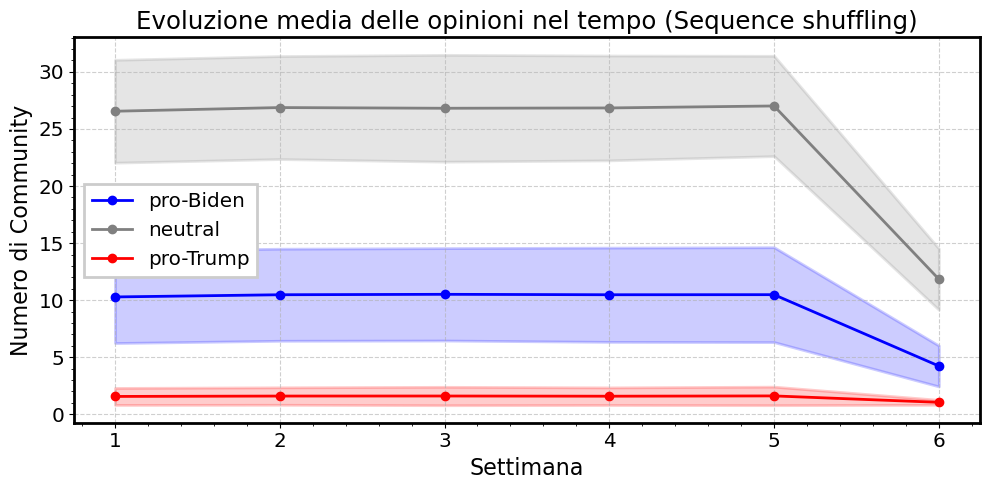

In [57]:
#Crea il plot
plt.figure(figsize=(10, 5))
colors = {"pro-Biden": "blue", "neutral": "gray", "pro-Trump": "red"}
for category in ["pro-Biden", "neutral", "pro-Trump"]:
    plt.plot(snapshots, averages_H0_seq[category], marker="o", linestyle="-", label=category, color=colors[category])
    plt.fill_between(snapshots,
                     averages_H0_seq[category] - stds_H0_seq[category],
                     averages_H0_seq[category] + stds_H0_seq[category],
                     color=colors[category], alpha=0.2)

plt.xlabel("Settimana")
plt.ylabel("Numero di Community")
plt.title("Evoluzione media delle opinioni nel tempo (Sequence shuffling)")
plt.xticks(snapshots)
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.savefig(os.path.join('plots', 'Sequence_shuffling.png'))
plt.show()

#### z-test: Sequence shuffling

Prima di eseguire lo z-test bisogna **verificare che le distribuzioni sono gaussiane**

Errore nel fitting per pro-Trump elemento 3: Optimal parameters not found: Number of calls to function has reached maxfev = 800.
Errore nel fitting per pro-Trump elemento 4: Optimal parameters not found: Number of calls to function has reached maxfev = 800.
Errore nel fitting per pro-Trump elemento 5: Optimal parameters not found: Number of calls to function has reached maxfev = 800.


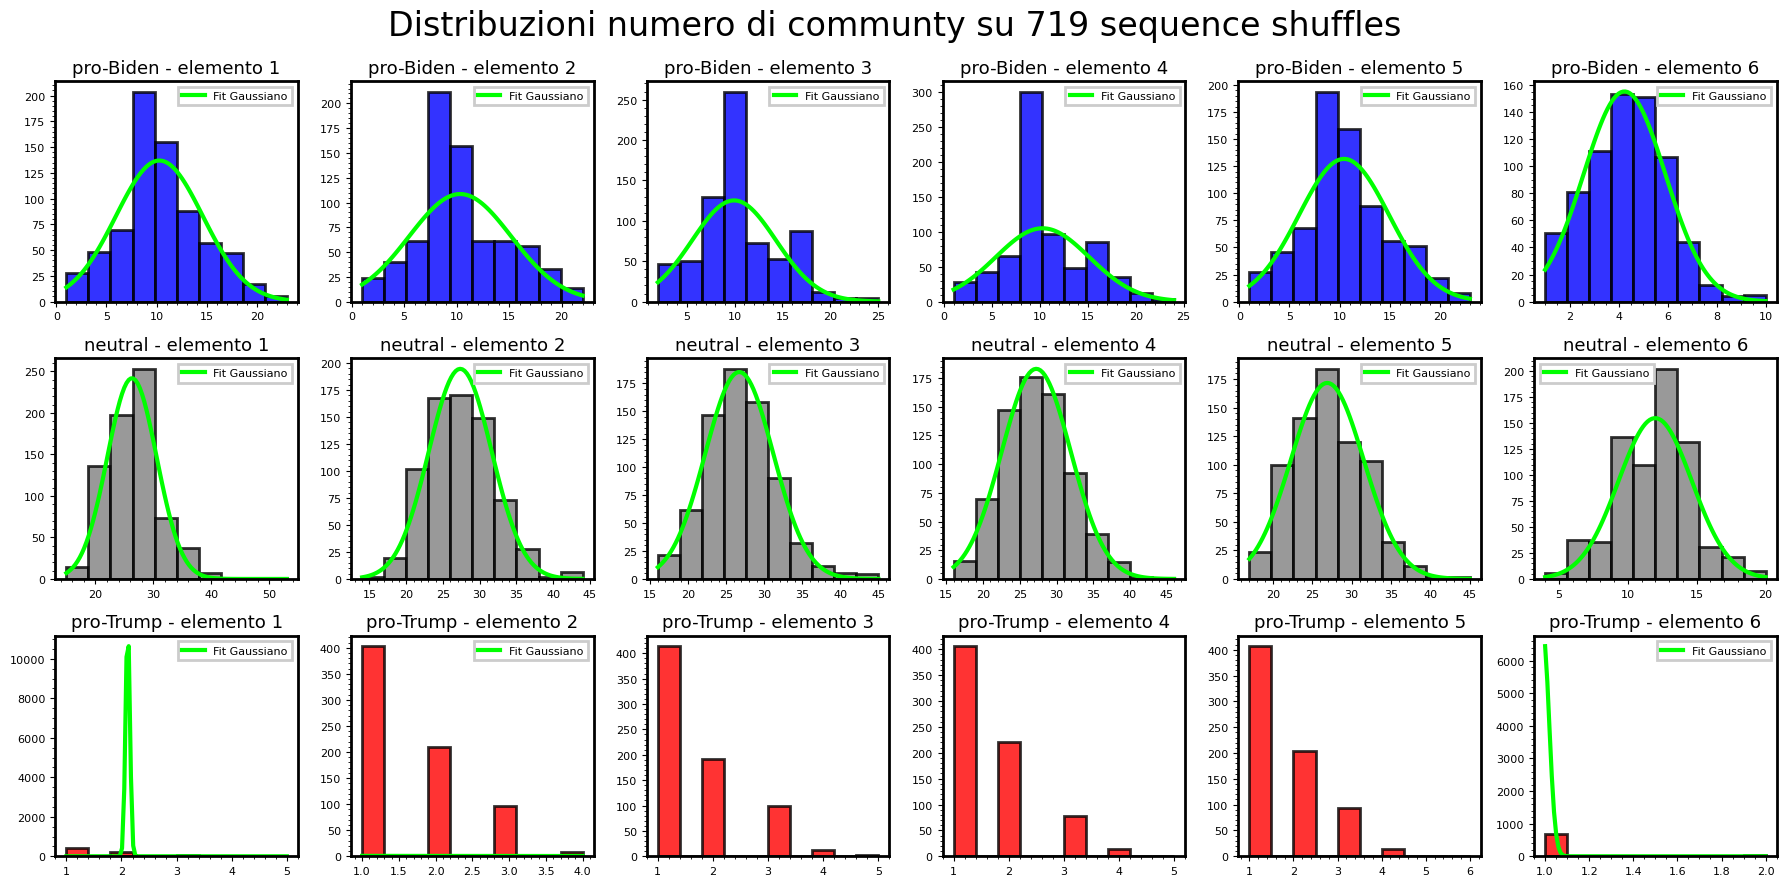


Valori chi^2/dof per ogni distribuzione:

pro-Biden elemento 1: 7.664864268804017
pro-Biden elemento 2: 15.789304350718732
pro-Biden elemento 3: 20.356761088890085
pro-Biden elemento 4: 25.259344975143584
pro-Biden elemento 5: 8.103084351622266
pro-Biden elemento 6: 2.178939794929447
neutral elemento 1: 6.004490724533341
neutral elemento 2: 3.284641047894037
neutral elemento 3: 1.2650223637389661
neutral elemento 4: 0.8494969826294744
neutral elemento 5: 2.48914010641538
neutral elemento 6: 10.481987510321801
pro-Trump elemento 1: 73.00000000840386
pro-Trump elemento 2: 102.34009683881301
pro-Trump elemento 3: None
pro-Trump elemento 4: None
pro-Trump elemento 5: None
pro-Trump elemento 6: 5.142857162472779


In [60]:
from scipy.optimize import curve_fit

# Funzione gaussiana
def gauss(x, A, mu, sigma):
    return A * np.exp(-((x - mu) ** 2) / (2 * sigma ** 2))

# Ordine delle categorie e definizione dei colori
categorie = ['pro-Biden', 'neutral', 'pro-Trump']
colori = {'pro-Biden': 'blue', 'neutral': 'gray', 'pro-Trump': 'red'}

# Dizionario per salvare i valori chi²/dof per ciascuna distribuzione
chi2_dict = {}

# Creazione della figura con griglia 3 righe x 6 colonne
fig, axes = plt.subplots(nrows=3, ncols=6, figsize=(18, 9))

# Loop sulle categorie (righe) e sui 6 elementi (colonne)
for r, cat in enumerate(categorie):
    for c in range(6):
        # Estrai la distribuzione: per ciascun dizionario prendi il valore in posizione c della categoria 'cat'
        distribuzione = [d[cat][c] for d in all_averages_H0_seq]
        ax = axes[r, c]

        # Usa plt.hist senza specificare i bin, in modo che la scelta avvenga automaticamente.
        counts, bin_edges, patches = ax.hist(distribuzione, color=colori[cat],
                                               alpha=0.8, edgecolor='black')
        # Calcola il centro dei bin (necessario per il fit)
        bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

        # Calcola l'errore di ciascun bin come radice quadrata del conteggio (errore poissoniano)
        # Per evitare divisioni per zero in fase di fitting, se il conteggio è zero assegniamo un errore di 1.
        errors = np.sqrt(counts)
        errors = np.where(errors == 0, 1.0, errors)

        # Stime iniziali per i parametri:
        # A: massimo dei conteggi, mu: media dei dati, sigma: deviazione standard (se zero, un valore piccolo)
        sigma_iniziale = np.std(distribuzione) if np.std(distribuzione) != 0 else 1e-3
        p0 = [max(counts), np.mean(distribuzione), sigma_iniziale]

        try:
            # Esegue il fit della gaussiana passando gli errori (sigma) per il peso dei dati
            popt, pcov = curve_fit(gauss, bin_centers, counts, p0=p0, sigma=errors, absolute_sigma=True)
            # Calcola il valore atteso per ciascun bin dalla gaussiana fit
            expected = gauss(bin_centers, *popt)
            # Calcola il chi²: somma ((osservato - atteso)^2 / errore^2) per ciascun bin
            chi2 = np.sum(((counts - expected) ** 2) / (errors ** 2))
            # Gradi di libertà = numero dei bin usati per il fit meno il numero dei parametri stimati (3)
            dof = len(counts) - 3
            chi2_ndof = chi2 / dof if dof != 0 else np.nan
            chi2_dict[f"{cat} elemento {c+1}"] = chi2_ndof

            # Genera la curva della gaussiana per il plot
            x_fit = np.linspace(bin_edges[0], bin_edges[-1], 100)
            y_fit = gauss(x_fit, *popt)
            ax.plot(x_fit, y_fit, '-', linewidth=3, color='lime', label='Fit Gaussiano')
            ax.legend(fontsize=8)
        except Exception as e:
            print(f"Errore nel fitting per {cat} elemento {c+1}: {e}")
            chi2_dict[f"{cat} elemento {c+1}"] = None

        ax.set_title(f"{cat} - elemento {c+1}", fontsize=13)
        ax.tick_params(axis='both', labelsize=8)


fig.suptitle(f"Distribuzioni numero di communty su {num_shuffles} sequence shuffles", fontsize=24)
plt.tight_layout()
plt.subplots_adjust(top=0.9)  # Lascia spazio per il titolo principale
plt.savefig(os.path.join('plots', 'Distribuzione_community_sequence_shuffles.png'))
plt.show()

# Stampa dei valori chi²/dof per ciascuna distribuzione
print("\nValori chi^2/dof per ogni distribuzione:\n")
for key, val in chi2_dict.items():
    print(f"{key}: {val}")


Le **distribuzioni delle popolozioni sono gaussiane** per **neutral** e **pro-Biden** (ricordo che i neutrali contengono i conservatori, quindi possiamo considerarli pro-Trump). Invece **le distribuzioni pro-Trump non sono gaussiane**, non possiamo trarre conslusioni dallo z-test da queste distribuzioni, c'è bisogno del t-test.

Lo z-score permette di confrontare la differenza osservata con la variabilità attesa sotto il modello nullo.

$$ z_{test} = \frac{\mu_{obs} - \mu_{H0}}{\sigma_{H0}/ \sqrt{N_{iter}}} $$

dove $N_{iter}$ è il numero di iterazioni (che equivale al numero di campioni osservati).

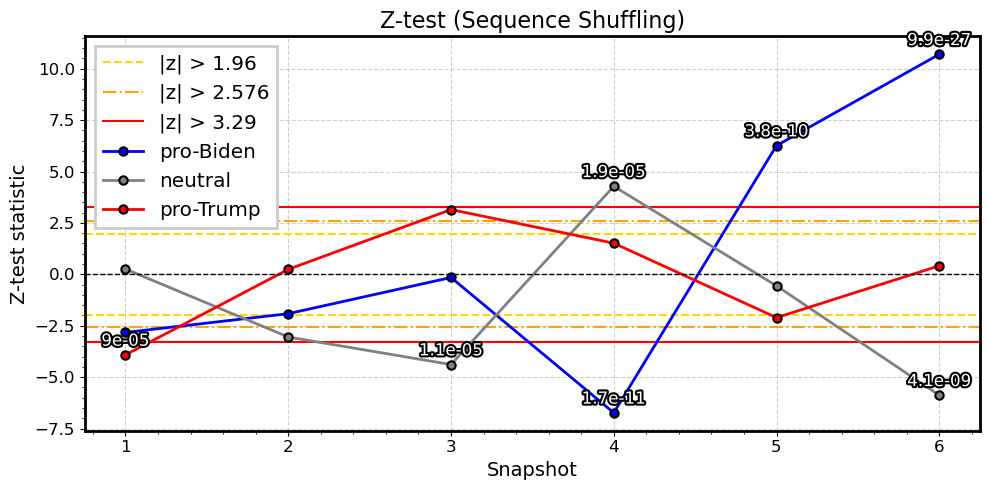

In [74]:
import matplotlib.patheffects as path_effects
from scipy.stats import norm

# Definizione dei colori per le categorie
colors = {"pro-Biden": "blue", "neutral": "gray", "pro-Trump": "red"}

plt.figure(figsize=(10, 5))

# Definizione delle soglie di significatività con linee orizzontali
thresholds = [1.960, 2.576, 3.290]
linestyles = ["dashed", "dashdot", "solid"]  # Diversi tipi di linea
line_colors = ["gold", "orange", "red"]  # Colori più distinti

# Disegna le linee orizzontali per le soglie di z-test
for i in range(3):
    plt.axhline(y=thresholds[i], color=line_colors[i], linestyle=linestyles[i], linewidth=1.5, label=f"|z| > {thresholds[i]}")
    plt.axhline(y=-thresholds[i], color=line_colors[i], linestyle=linestyles[i], linewidth=1.5)

# Plot delle curve z-test per ciascuna categoria
for category in ["pro-Biden", "neutral", "pro-Trump"]:
    z_test = (averages_H1[category] - averages_H0_seq[category]) / (stds_H0_seq[category] / np.sqrt(n_iter))
    plt.plot(snapshots, z_test, marker="o", linestyle="-", label=category, color=colors[category], linewidth=2, markeredgewidth=1.5, markeredgecolor="black")

    # Calcolo e visualizzazione dei p-values con effetto contorno nero
    for snap, z in zip(snapshots, z_test):
        p_value = 2 * norm.sf(abs(z))  # p-value test a due code
        if abs(z) > 3.29:  # Mostra il p-value solo se significativo
            plt.text(snap, z + 0.3, f"{p_value:.2g}", fontsize=12, ha="center", va="bottom",
                     color="white", path_effects=[plt.matplotlib.patheffects.withStroke(linewidth=3, foreground="black")])

# Aggiunta etichette e legenda
plt.axhline(y=0, color="black", linestyle="--", linewidth=1)  # Linea base a z=0
plt.xlabel("Snapshot", fontsize=14)
plt.ylabel("Z-test statistic", fontsize=14)
plt.title("Z-test (Sequence Shuffling)", fontsize=16)
plt.xticks(snapshots, fontsize=12)
plt.yticks(fontsize=12)
plt.legend(loc="upper left")#, bbox_to_anchor=(1, 1))
plt.grid(True, linestyle="--", alpha=0.6)

# Salvataggio e visualizzazione del grafico
plt.tight_layout()
plt.savefig(os.path.join('plots', 'Ztest_Sequence_shuffling.png'), dpi=300)
plt.show()



### Null model: Snapshot shuffling [NON UTILIZZATO]

In [ ]:
LOAD = True

if LOAD:
    with open(os.path.join("shuffles","H0_snapshot.json"), "r") as json_file:
        loaded_data = json.load(json_file)
    
    averages_H0_snap = {key: np.array(value) for key, value in loaded_data["averages_H0"].items()}
    stds_H0_snap = {key: np.array(value) for key, value in loaded_data["stds_H0"].items()}

    with open(os.path.join("shuffles","H0_snapshot_all.json"), 'r') as f:
        all_averages_H0_snap = json.load(f)

In [27]:
def snapshot_shuffling(snapshot_list):
    snapshot_shuffling_list = []
    
    for snapshot in snapshot_list:
        # Ottieni la sequenza dei gradi
        sequence = [d for n, d in snapshot.degree()]
        
        # Crea un grafo con il Configuration Model
        shuffled_graph = nx.configuration_model(sequence)
        
        # Converti in grafo semplice rimuovendo multiarchi e self-loop
        shuffled_graph = nx.Graph(shuffled_graph)  # Rimuove multigrafi
        shuffled_graph.remove_edges_from(nx.selfloop_edges(shuffled_graph))  # Rimuove self-loop
        
        # Mappa nodi originali -> nodi shuffle
        original_nodes = list(snapshot.nodes())
        shuffled_nodes = list(shuffled_graph.nodes())

        # Associa gli attributi originali ai nuovi nodi
        for original, shuffled in zip(original_nodes, shuffled_nodes):
            shuffled_graph.nodes[shuffled]['opinion'] = snapshot.nodes[original]['opinion']

        snapshot_shuffling_list.append(shuffled_graph)
    
    return snapshot_shuffling_list

In [29]:
num_shuffles = 30   
num_snapshots = len(principal_component_week_graph)
all_averages_H0_snap = []
#all_stds_H0_snap = []

for i in range(num_shuffles):
    print(f"Shuffle {i+1}/{num_shuffles}")
    # Crea snapshot attraveso configuration_model con lo stessa degree distribution
    shuffled_graphs = snapshot_shuffling(principal_component_week_graph.copy())
    
    # Crea una nuova istanza della classe con la lista mescolata
    analysis = CommunityEvolutionAnalysis(shuffled_graphs, threshold_percentile=75)
    
    # Calcola gli stats per questa lista (con n_iter iterazioni interne)
    averages, stds = analysis.analyze_community_evolution_multiple(iterations=n_iter,
                                                                   plot=False,
                                                                   save=False
                                                                  )
    # Salva i risultati
    all_averages_H0_snap.append(averages)
    #all_stds_H0_snap.append(stds)

# Calcola la media delle medie e la media delle stds
averages_H0_snap= {"pro-Biden": [], "neutral": [], "pro-Trump": []}
stds_H0_snap = {"pro-Biden": [], "neutral": [], "pro-Trump": []}

snapshots = np.array([s + 1 for s in range(num_snapshots)])  # Le settimane partono da 1
for category in averages_H0_snap.keys():
    for s in range(num_snapshots):
        # Raccogli tutti i valori per la snapshot s di questa categoria, provenienti dai vari shuffle
        values = [all_averages_H0_snap[i][category][s] for i in range(num_shuffles)]
        #std_values = [all_stds_H0_snap[i][category][s] for i in range(num_shuffles)]
        averages_H0_snap[category].append(np.mean(values))
        stds_H0_snap[category].append(np.std(values, ddof=1))#/np.sqrt(num_shuffles))

# Converti in array per il plotting
for category in averages_H0_snap:
    averages_H0_snap[category] = np.array(averages_H0_snap[category])
    stds_H0_snap[category] = np.array(stds_H0_snap[category])

Shuffle 1/30


100%|███████████████████████████████████████████| 30/30 [03:01<00:00,  6.04s/it]


Shuffle 2/30


100%|███████████████████████████████████████████| 30/30 [02:59<00:00,  5.97s/it]


Shuffle 3/30


100%|███████████████████████████████████████████| 30/30 [02:52<00:00,  5.75s/it]


Shuffle 4/30


100%|███████████████████████████████████████████| 30/30 [02:46<00:00,  5.56s/it]


Shuffle 5/30


100%|███████████████████████████████████████████| 30/30 [02:52<00:00,  5.73s/it]


Shuffle 6/30


100%|███████████████████████████████████████████| 30/30 [02:52<00:00,  5.75s/it]


Shuffle 7/30


100%|███████████████████████████████████████████| 30/30 [02:57<00:00,  5.92s/it]


Shuffle 8/30


100%|███████████████████████████████████████████| 30/30 [02:51<00:00,  5.72s/it]


Shuffle 9/30


100%|███████████████████████████████████████████| 30/30 [02:52<00:00,  5.75s/it]


Shuffle 10/30


100%|███████████████████████████████████████████| 30/30 [03:05<00:00,  6.19s/it]


Shuffle 11/30


100%|███████████████████████████████████████████| 30/30 [04:04<00:00,  8.16s/it]


Shuffle 12/30


100%|███████████████████████████████████████████| 30/30 [03:53<00:00,  7.80s/it]


Shuffle 13/30


100%|███████████████████████████████████████████| 30/30 [04:05<00:00,  8.18s/it]


Shuffle 14/30


100%|███████████████████████████████████████████| 30/30 [03:48<00:00,  7.61s/it]


Shuffle 15/30


100%|███████████████████████████████████████████| 30/30 [04:00<00:00,  8.02s/it]


Shuffle 16/30


100%|███████████████████████████████████████████| 30/30 [04:24<00:00,  8.80s/it]


Shuffle 17/30


100%|███████████████████████████████████████████| 30/30 [04:07<00:00,  8.25s/it]


Shuffle 18/30


100%|███████████████████████████████████████████| 30/30 [04:23<00:00,  8.77s/it]


Shuffle 19/30


100%|███████████████████████████████████████████| 30/30 [04:03<00:00,  8.12s/it]


Shuffle 20/30


100%|███████████████████████████████████████████| 30/30 [04:16<00:00,  8.54s/it]


Shuffle 21/30


100%|███████████████████████████████████████████| 30/30 [03:51<00:00,  7.71s/it]


Shuffle 22/30


100%|███████████████████████████████████████████| 30/30 [04:14<00:00,  8.48s/it]


Shuffle 23/30


100%|███████████████████████████████████████████| 30/30 [04:14<00:00,  8.50s/it]


Shuffle 24/30


100%|███████████████████████████████████████████| 30/30 [04:01<00:00,  8.06s/it]


Shuffle 25/30


100%|███████████████████████████████████████████| 30/30 [03:35<00:00,  7.18s/it]


Shuffle 26/30


100%|███████████████████████████████████████████| 30/30 [03:27<00:00,  6.92s/it]


Shuffle 27/30


100%|███████████████████████████████████████████| 30/30 [03:53<00:00,  7.78s/it]


Shuffle 28/30


100%|███████████████████████████████████████████| 30/30 [03:45<00:00,  7.51s/it]


Shuffle 29/30


100%|███████████████████████████████████████████| 30/30 [03:31<00:00,  7.06s/it]


Shuffle 30/30


100%|███████████████████████████████████████████| 30/30 [03:44<00:00,  7.48s/it]


In [30]:
SAVE = False

if SAVE:
    # Creazione del dizionario da salvare
    data = {
        "averages_H0": {key: value.tolist() for key, value in averages_H0_snap.items()},
        "stds_H0": {key: value.tolist() for key, value in stds_H0_snap.items()}
    }
    
    # Salvataggio in un file JSON
    with open(os.path.join("shuffles","H0_snapshot.json"), "w") as json_file:
        json.dump(data, json_file, indent=4)
    
    print("Dati salvati in H0_snapshot.json")

    ######### Salvataggio all_average #########
    # Converte gli array NumPy in liste
    data_json = []
    for d in all_averages_H0_snap:
        d_new = {}
        for key, value in d.items():
            d_new[key] = value.tolist()  # converte l'array in lista
        data_json.append(d_new)
    
    # Salvia i dati in formato JSON
    with open(os.path.join("shuffles","H0_snapshot_all.json"), 'w') as f:
        json.dump(data_json, f, indent=4)

    print("Dati salvati in H0_snapshot_all.json")

Dati salvati in H0_snapshot.json
Dati salvati in H0_snapshot_all.json


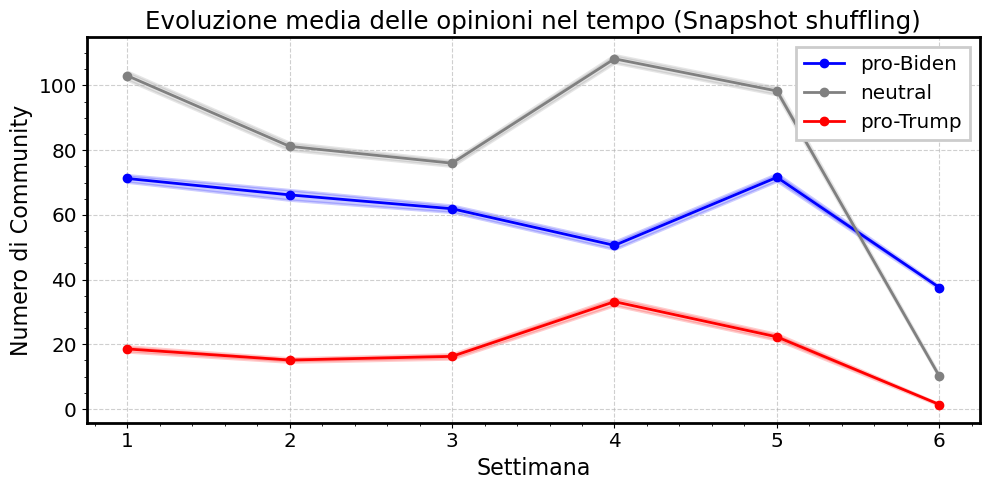

In [32]:
# Crea il plot
plt.figure(figsize=(10, 5))
colors = {"pro-Biden": "blue", "neutral": "gray", "pro-Trump": "red"}
for category in ["pro-Biden", "neutral", "pro-Trump"]:
    plt.plot(snapshots, averages_H0_snap[category], marker="o", linestyle="-", label=category, color=colors[category])
    plt.fill_between(snapshots,
                     averages_H0_snap[category] - stds_H0_snap[category],
                     averages_H0_snap[category] + stds_H0_snap[category],
                     color=colors[category], alpha=0.2)

plt.xlabel("Settimana")
plt.ylabel("Numero di Community")
plt.title("Evoluzione media delle opinioni nel tempo (Snapshot shuffling)")
plt.xticks(snapshots)
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.savefig(os.path.join('plots', 'Snapshot_shuffling.png'))
plt.show()

#### z-test: Snapshot shuffling

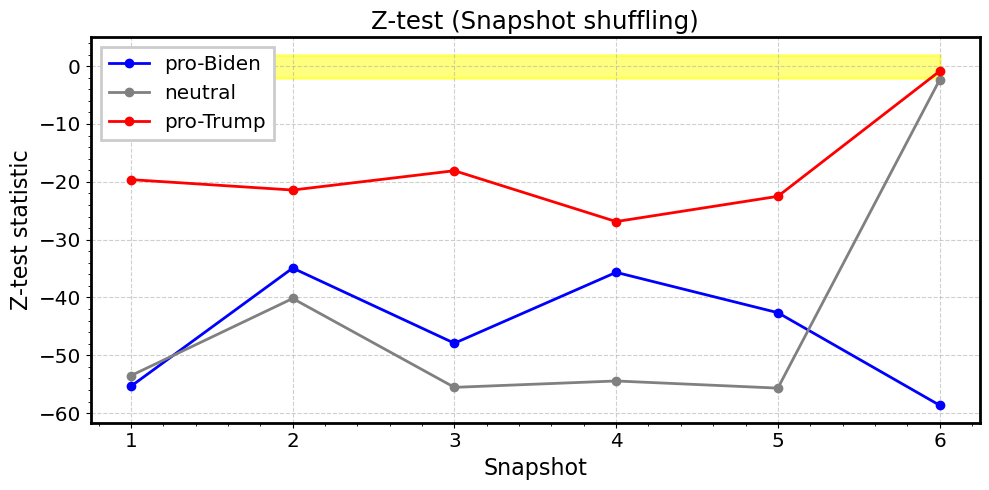

In [33]:
# Definizione dei colori per le categorie
colors = {"pro-Biden": "blue", "neutral": "gray", "pro-Trump": "red"}

plt.figure(figsize=(10, 5))

for category in ["pro-Biden", "neutral", "pro-Trump"]:
    # Calcolo del valore del z-test per ciascun snapshot:
    z_test = (averages_H1[category] - averages_H0_snap[category]) / (stds_H0_snap[category]/np.sqrt(n_iter))
    
    # Plot del valore z-test e della banda
    plt.plot(snapshots, z_test, marker="o", linestyle="-", label=category, color=colors[category])
plt.fill_between(snapshots, -1.96, 1.96, color='yellow', alpha=0.5)

plt.xlabel("Snapshot")
plt.ylabel("Z-test statistic")
plt.title("Z-test (Snapshot shuffling)")
plt.xticks(snapshots)
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.savefig(os.path.join('plots', 'Ztest_Snapshot_shuffling.png'))
plt.show()

### Null model: Sequence + Snapshot shuffling [NON UTILIZZATO]

In [ ]:
LOAD = True

if LOAD:
    with open(os.path.join("shuffles","H0_sequence_snapshot.json"), "r") as json_file:
        loaded_data = json.load(json_file)
    
    averages_H0_seq_snap = {key: np.array(value) for key, value in loaded_data["averages_H0"].items()}
    stds_H0_seq_snap = {key: np.array(value) for key, value in loaded_data["stds_H0"].items()}

    with open(os.path.join("shuffles","H0_sequence_snapshot_all.json"), 'r') as f:
        all_averages_H0_seq_snap = json.load(f)

In [34]:
num_shuffles = 30   
num_snapshots = len(principal_component_week_graph)
all_averages_H0_seq_snap = []
#all_stds_H0_seq_snap = []

for i in range(num_shuffles):
    print(f"Shuffle {i+1}/{num_shuffles}")
    
    # Crea una copia della lista originale e la mescola
    shuffled_graphs = principal_component_week_graph.copy()
    random.shuffle(shuffled_graphs)
    
    # Crea snapshot attraveso configuration_model con lo stessa degree distribution
    shuffled_graphs = snapshot_shuffling(shuffled_graphs)
    
    # Crea una nuova istanza della classe con la lista mescolata
    analysis = CommunityEvolutionAnalysis(shuffled_graphs, threshold_percentile=75)
    
    # Calcola gli stats per questa lista (con n_iter iterazioni interne)
    averages, stds = analysis.analyze_community_evolution_multiple(iterations=n_iter,
                                                                   plot=False,
                                                                   save=False
                                                                  )
    # Salva i risultati
    all_averages_H0_seq_snap.append(averages)
    #all_stds_H0_seq_snap.append(stds)

# Calcola la media delle medie e la media delle stds
averages_H0_seq_snap= {"pro-Biden": [], "neutral": [], "pro-Trump": []}
stds_H0_seq_snap = {"pro-Biden": [], "neutral": [], "pro-Trump": []}

snapshots = np.array([s + 1 for s in range(num_snapshots)])  # Le settimane partono da 1
for category in averages_H0_seq_snap.keys():
    for s in range(num_snapshots):
        # Raccogli tutti i valori per la snapshot s di questa categoria, provenienti dai vari shuffle
        values = [all_averages_H0_seq_snap[i][category][s] for i in range(num_shuffles)]
        #std_values = [all_stds_H0_seq_snap[i][category][s] for i in range(num_shuffles)]
        averages_H0_seq_snap[category].append(np.mean(values))
        stds_H0_seq_snap[category].append(np.std(values, ddof=1))#/np.sqrt(num_shuffles))

# Converti in array per il plotting
for category in averages_H0_seq_snap:
    averages_H0_seq_snap[category] = np.array(averages_H0_seq_snap[category])
    stds_H0_seq_snap[category] = np.array(stds_H0_seq_snap[category])

Shuffle 1/30


100%|███████████████████████████████████████████| 30/30 [02:58<00:00,  5.96s/it]


Shuffle 2/30


100%|███████████████████████████████████████████| 30/30 [02:53<00:00,  5.77s/it]


Shuffle 3/30


100%|███████████████████████████████████████████| 30/30 [02:45<00:00,  5.52s/it]


Shuffle 4/30


100%|███████████████████████████████████████████| 30/30 [02:46<00:00,  5.55s/it]


Shuffle 5/30


100%|███████████████████████████████████████████| 30/30 [02:52<00:00,  5.76s/it]


Shuffle 6/30


100%|███████████████████████████████████████████| 30/30 [02:48<00:00,  5.63s/it]


Shuffle 7/30


100%|███████████████████████████████████████████| 30/30 [02:40<00:00,  5.36s/it]


Shuffle 8/30


100%|███████████████████████████████████████████| 30/30 [03:01<00:00,  6.05s/it]


Shuffle 9/30


100%|███████████████████████████████████████████| 30/30 [04:13<00:00,  8.44s/it]


Shuffle 10/30


100%|███████████████████████████████████████████| 30/30 [04:02<00:00,  8.08s/it]


Shuffle 11/30


100%|███████████████████████████████████████████| 30/30 [04:19<00:00,  8.67s/it]


Shuffle 12/30


100%|███████████████████████████████████████████| 30/30 [03:54<00:00,  7.80s/it]


Shuffle 13/30


100%|███████████████████████████████████████████| 30/30 [03:43<00:00,  7.47s/it]


Shuffle 14/30


100%|███████████████████████████████████████████| 30/30 [03:45<00:00,  7.51s/it]


Shuffle 15/30


100%|███████████████████████████████████████████| 30/30 [03:30<00:00,  7.00s/it]


Shuffle 16/30


100%|███████████████████████████████████████████| 30/30 [03:48<00:00,  7.62s/it]


Shuffle 17/30


100%|███████████████████████████████████████████| 30/30 [03:17<00:00,  6.58s/it]


Shuffle 18/30


100%|███████████████████████████████████████████| 30/30 [03:47<00:00,  7.58s/it]


Shuffle 19/30


100%|███████████████████████████████████████████| 30/30 [03:30<00:00,  7.02s/it]


Shuffle 20/30


100%|███████████████████████████████████████████| 30/30 [03:17<00:00,  6.57s/it]


Shuffle 21/30


100%|███████████████████████████████████████████| 30/30 [03:27<00:00,  6.93s/it]


Shuffle 22/30


100%|███████████████████████████████████████████| 30/30 [03:41<00:00,  7.38s/it]


Shuffle 23/30


100%|███████████████████████████████████████████| 30/30 [03:27<00:00,  6.92s/it]


Shuffle 24/30


100%|███████████████████████████████████████████| 30/30 [03:36<00:00,  7.21s/it]


Shuffle 25/30


100%|███████████████████████████████████████████| 30/30 [03:29<00:00,  6.97s/it]


Shuffle 26/30


100%|███████████████████████████████████████████| 30/30 [03:53<00:00,  7.77s/it]


Shuffle 27/30


100%|███████████████████████████████████████████| 30/30 [03:47<00:00,  7.58s/it]


Shuffle 28/30


100%|███████████████████████████████████████████| 30/30 [03:41<00:00,  7.39s/it]


Shuffle 29/30


100%|███████████████████████████████████████████| 30/30 [03:33<00:00,  7.12s/it]


Shuffle 30/30


100%|███████████████████████████████████████████| 30/30 [03:26<00:00,  6.88s/it]


In [35]:
SAVE = False

if SAVE:
    # Creazione del dizionario da salvare
    data = {
        "averages_H0": {key: value.tolist() for key, value in averages_H0_seq_snap.items()},
        "stds_H0": {key: value.tolist() for key, value in stds_H0_seq_snap.items()}
    }
    
    # Salvataggio in un file JSON
    with open(os.path.join("shuffles","H0_sequence_snapshot.json"), "w") as json_file:
        json.dump(data, json_file, indent=4)
    
    print("Dati salvati in H0_sequence_snapshot.json")

    ######### Salvataggio all_average #########
    # Converte gli array NumPy in liste
    data_json = []
    for d in all_averages_H0_seq_snap:
        d_new = {}
        for key, value in d.items():
            d_new[key] = value.tolist()  # converte l'array in lista
        data_json.append(d_new)
    
    # Salvia i dati in formato JSON
    with open(os.path.join("shuffles","H0_sequence_snapshot_all.json"), 'w') as f:
        json.dump(data_json, f, indent=4)

    print("Dati salvati in H0_sequence_snapshot_all.json")

Dati salvati in H0_sequence_snapshot.json
Dati salvati in H0_sequence_snapshot_all.json


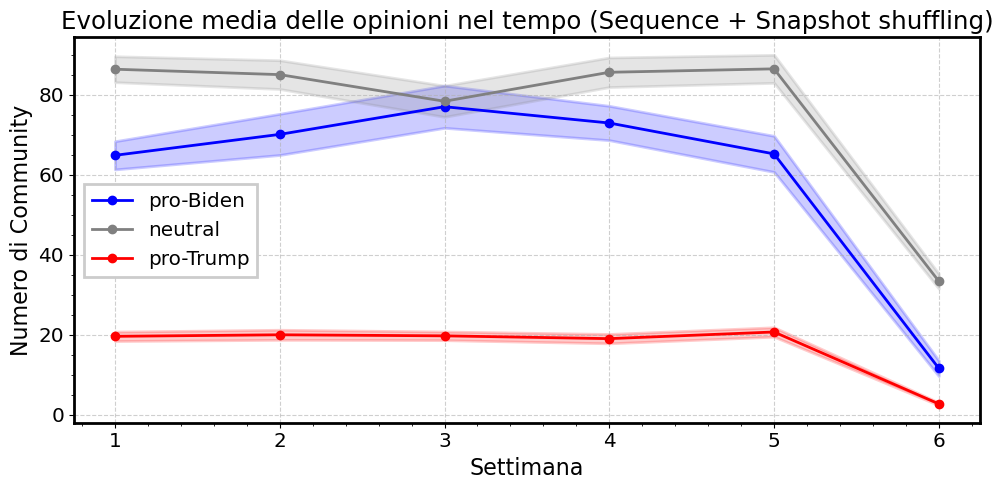

In [36]:
# Crea il plot
plt.figure(figsize=(10, 5))
colors = {"pro-Biden": "blue", "neutral": "gray", "pro-Trump": "red"}
for category in ["pro-Biden", "neutral", "pro-Trump"]:
    plt.plot(snapshots, averages_H0_seq_snap[category], marker="o", linestyle="-", label=category, color=colors[category])
    plt.fill_between(snapshots,
                     averages_H0_seq_snap[category] - stds_H0_seq_snap[category],
                     averages_H0_seq_snap[category] + stds_H0_seq_snap[category],
                     color=colors[category], alpha=0.2)

plt.xlabel("Settimana")
plt.ylabel("Numero di Community")
plt.title("Evoluzione media delle opinioni nel tempo (Sequence + Snapshot shuffling)")
plt.xticks(snapshots)
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.savefig(os.path.join('plots', 'Sequence_Snapshot_shuffling.png'))
plt.show()

#### z-test: Sequence + Snapshot shuffling

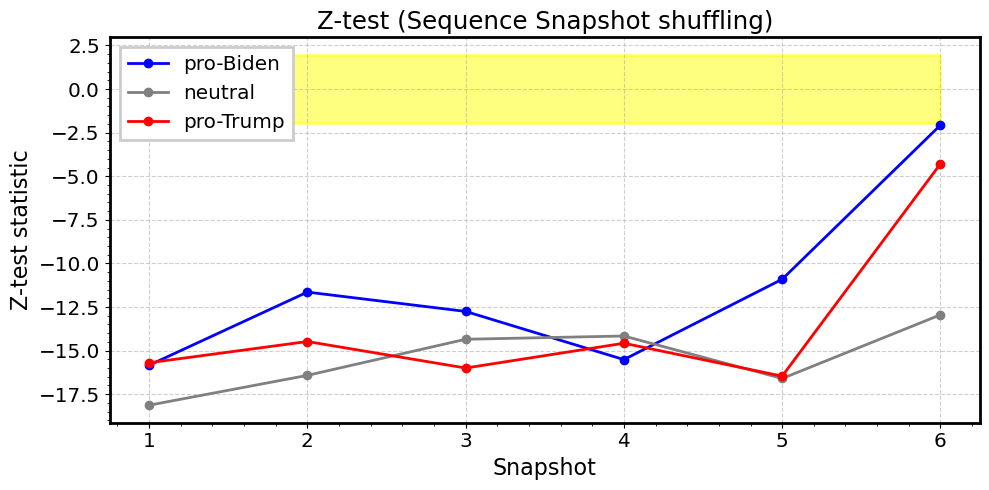

In [37]:
# Definizione dei colori per le categorie
colors = {"pro-Biden": "blue", "neutral": "gray", "pro-Trump": "red"}

plt.figure(figsize=(10, 5))

for category in ["pro-Biden", "neutral", "pro-Trump"]:
    # Calcolo del valore del z-test per ciascun snapshot:
    z_test = (averages_H1[category] - averages_H0_seq_snap[category]) / (stds_H0_seq_snap[category]/np.sqrt(n_iter))
    
    # Plot del valore z-test e della banda
    plt.plot(snapshots, z_test, marker="o", linestyle="-", label=category, color=colors[category])
plt.fill_between(snapshots, -1.96, 1.96, color='yellow', alpha=0.5)

plt.xlabel("Snapshot")
plt.ylabel("Z-test statistic")
plt.title("Z-test (Sequence Snapshot shuffling)")
plt.xticks(snapshots)
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.savefig(os.path.join('plots', 'Ztest_Sequence_Snapshot_shuffling.png'))
plt.show()